# Challenge
In this module, we learned how to approach and solve regression problems using linear regression models. Throughout the module, you worked on a house price dataset from Kaggle. In this challenge, you will keep working on this dataset.

# The scenario
The housing market is one of the most crucial parts of the economy for every country. Purchasing a home is one of the primary ways to build wealth and savings for people. In this respect, predicting prices in the housing market is a very central topic in economic and financial circles.

The house price dataset from Kaggle includes several features of the houses along with their sale prices at the time they are sold. So far, in this module, you built and implemented some models using this dataset.

In this challenge, you are required to improve your model with respect to its prediction performance.

To complete this challenge, submit a Jupyter notebook containing your solutions to the following tasks.

# Steps
1. Load the houseprices data from Thinkful's database.
2. Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.
3. Now, split your data into train and test sets where 20% of the data resides in the test set.
4. Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!
5. Evaluate your best model on the test set.
6. So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

# Import stat packages
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats.stats import ttest_ind
from scipy.stats.mstats import winsorize
from scipy.stats import zscore
import scipy.stats as stats
from scipy.stats import boxcox

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing

from sklearn import linear_model
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
import statsmodels.api as sm
from sklearn import linear_model
from statsmodels.formula.api import ols
from sklearn import linear_model

from sklearn.preprocessing import Imputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

## Load Data

In [2]:
# Load the data from the PostgreSQL database and print out some observations:

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df_houseprices = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
#pd.reset_option('display.float_format')
pd.set_option('display.max_columns', 999)
df_houseprices.head(10)

id  mssubclass mszoning  lotfrontage  lotarea street alley lotshape  \
0   1          60       RL       65.000     8450   Pave  None      Reg   
1   2          20       RL       80.000     9600   Pave  None      Reg   
2   3          60       RL       68.000    11250   Pave  None      IR1   
3   4          70       RL       60.000     9550   Pave  None      IR1   
4   5          60       RL       84.000    14260   Pave  None      IR1   
5   6          50       RL       85.000    14115   Pave  None      IR1   
6   7          20       RL       75.000    10084   Pave  None      Reg   
7   8          60       RL          nan    10382   Pave  None      IR1   
8   9          50       RM       51.000     6120   Pave  None      Reg   
9  10         190       RL       50.000     7420   Pave  None      Reg   

  landcontour utilities lotconfig landslope neighborhood condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   
5         Lvl    AllPub    Inside       Gtl      Mitchel       Norm   
6         Lvl    AllPub    Inside       Gtl      Somerst       Norm   
7         Lvl    AllPub    Corner       Gtl       NWAmes       PosN   
8         Lvl    AllPub    Inside       Gtl      OldTown     Artery   
9         Lvl    AllPub    Corner       Gtl      BrkSide     Artery   

  condition2 bldgtype housestyle  overallqual  overallcond  yearbuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   
5       Norm     1Fam     1.5Fin            5            5       1993   
6       Norm     1Fam     1Story            8            5       2004   
7       Norm     1Fam     2Story            7            6       1973   
8       Norm     1Fam     1.5Fin            7            5       1931   
9     Artery   2fmCon     1.5Unf            5            6       1939   

   yearremodadd roofstyle roofmatl exterior1st exterior2nd masvnrtype  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   
5          1995     Gable  CompShg     VinylSd     VinylSd       None   
6          2005     Gable  CompShg     VinylSd     VinylSd      Stone   
7          1973     Gable  CompShg     HdBoard     HdBoard      Stone   
8          1950     Gable  CompShg     BrkFace     Wd Shng       None   
9          1950     Gable  CompShg     MetalSd     MetalSd       None   

   masvnrarea exterqual extercond foundation bsmtqual bsmtcond bsmtexposure  \
0     196.000        Gd        TA      PConc       Gd       TA           No   
1       0.000        TA        TA     CBlock       Gd       TA           Gd   
2     162.000        Gd        TA      PConc       Gd       TA           Mn   
3       0.000        TA        TA     BrkTil       TA       Gd           No   
4     350.000        Gd        TA      PConc       Gd       TA           Av   
5       0.000        TA        TA       Wood       Gd       TA           No   
6     186.000        Gd        TA      PConc       Ex       TA           Av   
7     240.000        TA        TA     CBlock       Gd       TA           Mn   
8       0.000        TA        TA     BrkTil       TA       TA           No   
9       

## Data Exploration

In [3]:
df_houseprices.shape

(1460, 81)

In [4]:
df_houseprices.get_dtype_counts() 

float64     3
int64      35
object     43
dtype: int64

In [5]:
df_houseprices.describe()

id  mssubclass  lotfrontage    lotarea  overallqual  overallcond  \
count 1460.000    1460.000     1201.000   1460.000     1460.000     1460.000   
mean   730.500      56.897       70.050  10516.828        6.099        5.575   
std    421.610      42.301       24.285   9981.265        1.383        1.113   
min      1.000      20.000       21.000   1300.000        1.000        1.000   
25%    365.750      20.000       59.000   7553.500        5.000        5.000   
50%    730.500      50.000       69.000   9478.500        6.000        5.000   
75%   1095.250      70.000       80.000  11601.500        7.000        6.000   
max   1460.000     190.000      313.000 215245.000       10.000        9.000   

       yearbuilt  yearremodadd  masvnrarea  bsmtfinsf1  bsmtfinsf2  bsmtunfsf  \
count   1460.000      1460.000    1452.000    1460.000    1460.000   1460.000   
mean    1971.268      1984.866     103.685     443.640      46.549    567.240   
std       30.203        20.645     181.066     456.098     161.319    441.867   
min     1872.000      1950.000       0.000       0.000       0.000      0.000   
25%     1954.000      1967.000       0.000       0.000       0.000    223.000   
50%     1973.000      1994.000       0.000     383.500       0.000    477.500   
75%     2000.000      2004.000     166.000     712.250       0.000    808.000   
max     2010.000      2010.000    1600.000    5644.000    1474.000   2336.000   

       totalbsmtsf  firstflrsf  secondflrsf  lowqualfinsf  grlivarea  \
count     1460.000    1460.000     1460.000      1460.000   1460.000   
mean      1057.429    1162.627      346.992         5.845   1515.464   
std        438.705     386.588      436.528        48.623    525.480   
min          0.000     334.000        0.000         0.000    334.000   
25%        795.750     882.000        0.000         0.000   1129.500   
50%        991.500    1087.000        0.000         0.000   1464.000   
75%       1298.250    1391.250      728.000         0.000   1776.750   
max       6110.000    4692.000     2065.000       572.000   5642.000   

       bsmtfullbath  bsmthalfbath  fullbath  halfbath  bedroomabvgr  \
count      1460.000      1460.000  1460.000  1460.000      1460.000   
mean          0.425         0.058     1.565     0.383         2.866   
std           0.519         0.239     0.551     0.503         0.816   
min           0.000         0.000     0.000     0.000         0.000   
25%           0.000         0.000     1.000     0.000         2.000   
50%           0.000         0.000     2.000     0.000         3.000   
75%           1.000         0.000     2.000     1.000         3.000   
max           3.000         2.000     3.000     2.000         8.000   

       kitchenabvgr  totrmsabvgrd  fireplaces  garageyrblt  garagecars  \
count      1460.000      1460.000    1460.000     1379.000    1460.000   
mean          1.047         6.518       0.613     1978.506       1.767   
std           0.220         1.625       0.645       24.690       0.747   
min           0.000         2.000       0.000     1900.000       0.000   
25%           1.000         5.000       0.000     1961.000       1.000   
50%           1.000         6.000       1.000     1980.000       2.000   
75%           1.000         7.000       1.000     2002.000       2.000   
max           3.000        14.000       3.000     2010.000       4.000   

       garagearea  wooddecksf  openporchsf  enclosedporch  threessnporch  \
count    1460.000    1460.000     1460.000       1460.000       1460.000   
mean      472.980      94.245       46.660         21.954          3.410   
std       213.805     125.339       66.256         61.119         29.317   
min         0.000       0.000        0.000          0.000          0.000   
25%       334.500       0.000        0.000          0.000          0.000   
50%       480.000       0.000       25.000          0.000          0.000   
75%       576.000     168.000       68.000          0.000          0.000 

In [6]:
df_houseprices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [7]:
# determine which columns are likely categorical vs continuous variables
# look at the lower numbers to recognize potential categorical variables
df_houseprices.nunique().sort_values()

centralair          2
utilities           2
street              2
alley               2
bsmthalfbath        3
landslope           3
garagefinish        3
halfbath            3
paveddrive          3
poolqc              3
fullbath            4
masvnrtype          4
bsmtexposure        4
exterqual           4
miscfeature         4
bsmtfullbath        4
fence               4
kitchenqual         4
bsmtcond            4
fireplaces          4
landcontour         4
lotshape            4
kitchenabvgr        4
bsmtqual            4
fireplacequ         5
electrical          5
yrsold              5
garagecars          5
garagequal          5
garagecond          5
                 ... 
overallqual        10
totrmsabvgrd       12
mosold             12
exterior1st        15
mssubclass         15
exterior2nd        16
threessnporch      20
miscval            21
lowqualfinsf       24
neighborhood       25
yearremodadd       61
screenporch        76
garageyrblt        97
lotfrontage       110
yearbuilt 

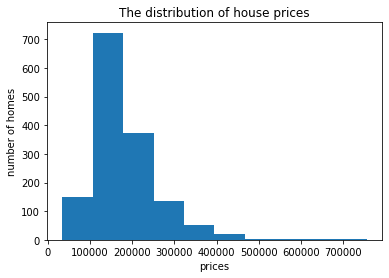

In [8]:
plt.hist(df_houseprices.saleprice)
plt.title("The distribution of house prices")
plt.xlabel("prices")
plt.ylabel("number of homes")
plt.show()

The house prices seem to be skewed to the right.

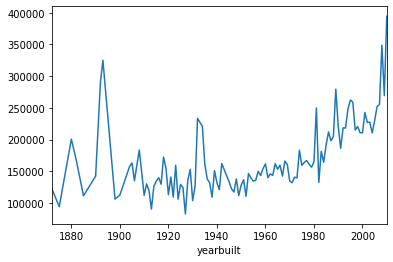

In [9]:
df_houseprices.groupby('yearbuilt')['saleprice'].mean().plot()

NOTICE: The above graph is NOT historical sale price of homes. This is a graph that displays original build year of each home, and for how much it was RECENTLY sold (2006-2010). With a few exceptions, older homes sold for less than newer homes. It also appears that the lowest valued homes were built in the 20s-30s. 

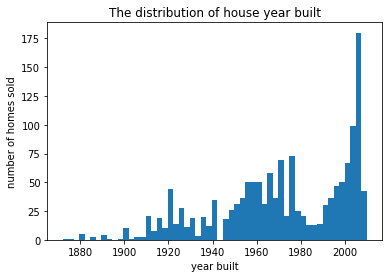

In [10]:
plt.hist(df_houseprices.yearbuilt, bins = 55)
plt.title("The distribution of house year built")
plt.xlabel("year built")
plt.ylabel("number of homes sold")
plt.show()

The above graph displays the distribution of original build year for each home sold. Bins set to number of months in the data set.

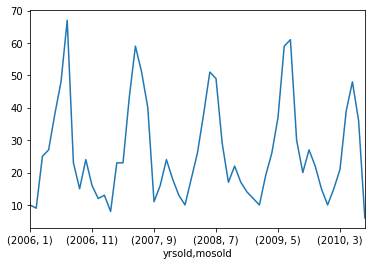

In [11]:
df_houseprices.groupby(['yrsold', 'mosold'])['saleprice'].count().plot()

In [12]:
df_houseprices.groupby(['yrsold', 'mosold'])['saleprice'].count()

yrsold  mosold
2006    1         10
        2          9
        3         25
        4         27
        5         38
        6         48
        7         67
        8         23
        9         15
        10        24
        11        16
        12        12
2007    1         13
        2          8
        3         23
        4         23
        5         43
        6         59
        7         51
        8         40
        9         11
        10        16
        11        24
        12        18
2008    1         13
        2         10
        3         18
        4         26
        5         38
        6         51
        7         49
        8         29
        9         17
        10        22
        11        17
        12        14
2009    1         12
        2         10
        3         19
        4         26
        5         37
        6         59
        7         61
        8         30
        9         20
        10        27
        11        2

Will remove house sales that occurred during month 7 (July) of 2010 due to potential data collection issues.

- It appears the sale of homes dates back to only 2006. 
- As one would expect from anecdotal information, the frequency of house sales increase in the spring/summer months. There also appears to be a second, smaller increase proceeding the main spike.

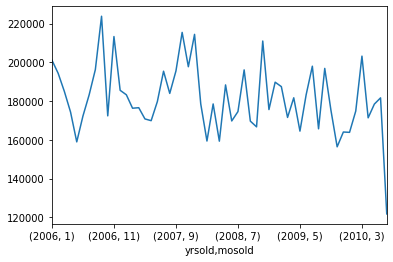

In [13]:
df_houseprices.groupby(['yrsold', 'mosold'])['saleprice'].mean().plot()

The general trend of house prices appear to decline throughout this dataset. This is a generality and the range of dates for house sales is only from 2006 to 2010.

Like in a previous challenge, there's use in making a numbers column list, so we don't mistake word columns with number columns.

In [14]:
num_cols = df_houseprices.select_dtypes(['int64', 'float64']).columns
print(num_cols)

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')


In [15]:
non_numeric_columns = df_houseprices.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numerical columns is 43


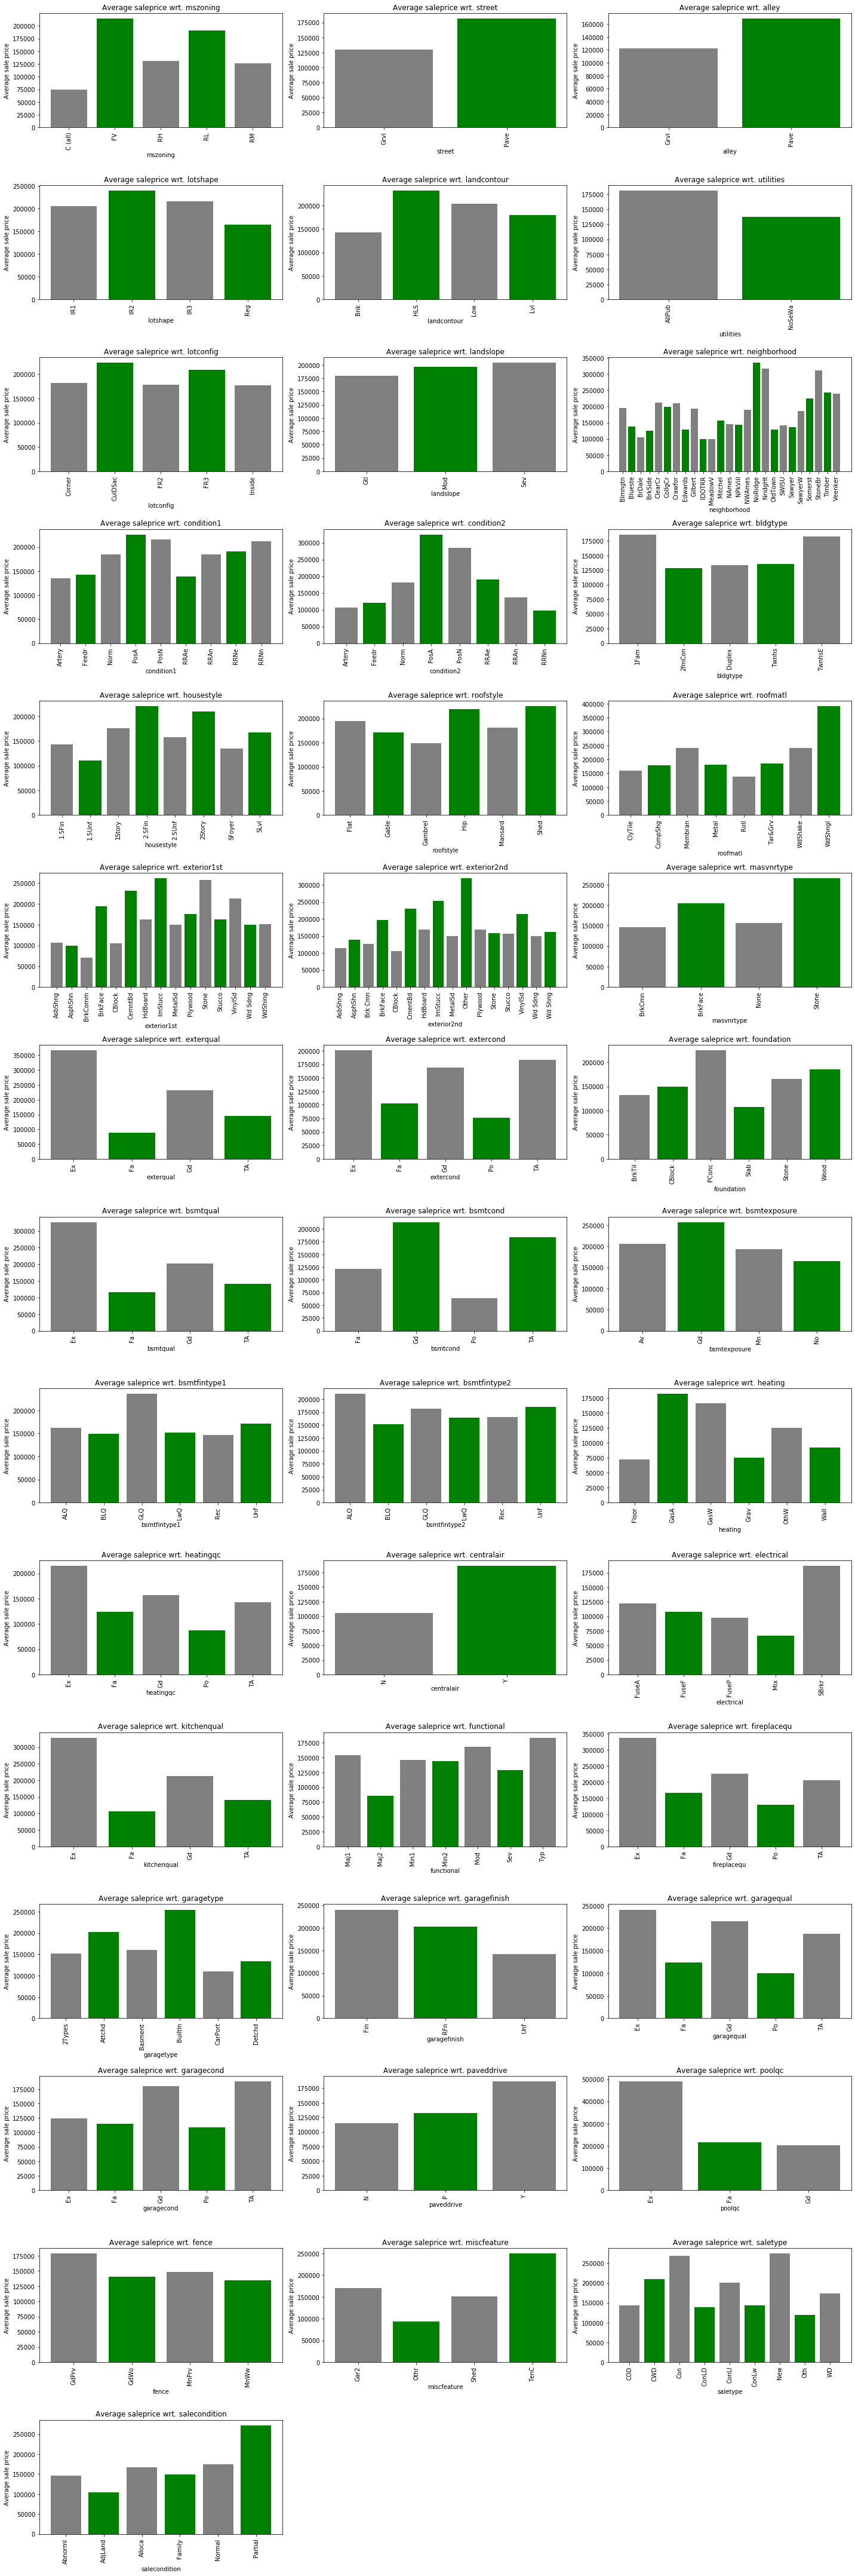

In [16]:
plt.figure(figsize=(20,60))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(15,3,index+1)
    plt.bar(df_houseprices.groupby(column)["saleprice"].mean().index, df_houseprices.groupby(column)["saleprice"].mean(),
           color=("grey","green"))
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

## Data Cleanup - Nulls

We also know there are nulls in the number columns. Let's fill them.

In [17]:
# create new dataframe to maintain original version
df_houseprices2 = df_houseprices.copy()

In [18]:
# Count how many nulls there are per column
total_nulls = df_houseprices2.isna().sum()
total_nulls.sort_values(inplace=True, ascending = False)

# Observe the percentage of nulls in each column
percent_nulls = df_houseprices2.isna().sum()* 100 / len(df_houseprices2)
percent_nulls.sort_values(inplace=True, ascending = False)

print('total nulls per column')
print(total_nulls)
print('------------------------\npercent nulls per column')
print(percent_nulls)

total nulls per column
poolqc           1453
miscfeature      1406
alley            1369
fence            1179
fireplacequ       690
lotfrontage       259
garagecond         81
garagetype         81
garageyrblt        81
garagefinish       81
garagequal         81
bsmtexposure       38
bsmtfintype2       38
bsmtfintype1       37
bsmtcond           37
bsmtqual           37
masvnrarea          8
masvnrtype          8
electrical          1
utilities           0
yearremodadd        0
mssubclass          0
foundation          0
extercond           0
exterqual           0
exterior2nd         0
exterior1st         0
roofmatl            0
roofstyle           0
yearbuilt           0
                 ... 
garagearea          0
paveddrive          0
wooddecksf          0
openporchsf         0
threessnporch       0
bsmtunfsf           0
screenporch         0
poolarea            0
miscval             0
mosold              0
yrsold              0
saletype            0
functional          0
totrmsabv

In [19]:
numerics = ['float64', 'int64']
num_cols = df_houseprices2.select_dtypes(include = numerics).columns
word_cols = df_houseprices2.select_dtypes(include = object).columns

In [20]:
# Find columns which has null values and data type object
fill_na_word_columns = []
for column_name in df_houseprices2.columns:
    if df_houseprices2[column_name].isnull().any() and df_houseprices2[column_name].dtype==object:
        fill_na_word_columns.append(column_name)
        
print(fill_na_word_columns)

['alley', 'masvnrtype', 'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'electrical', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal', 'garagecond', 'poolqc', 'fence', 'miscfeature']


In [21]:
# Fill "None" in object columns to replace nulls
for col_name in fill_na_word_columns:
    df_houseprices2[col_name].fillna("NONE",inplace=True)

In [22]:
# Find columns which has null values and data numerical data
fill_na_numeric_columns = []
for column_name in num_cols:
    if df_houseprices2[column_name].isnull().any():
        fill_na_numeric_columns.append(column_name)
        
print(fill_na_numeric_columns)

['lotfrontage', 'masvnrarea', 'garageyrblt']


Let's learn a little more about these numerical columns. Why are they nulls? How should we proceed?

In [23]:
df_houseprices2[['lotfrontage', 'masvnrarea', 'masvnrtype', 'garageyrblt','garagecars']]

lotfrontage  masvnrarea masvnrtype  garageyrblt  garagecars
0          65.000     196.000    BrkFace     2003.000           2
1          80.000       0.000       None     1976.000           2
2          68.000     162.000    BrkFace     2001.000           2
3          60.000       0.000       None     1998.000           3
4          84.000     350.000    BrkFace     2000.000           3
5          85.000       0.000       None     1993.000           2
6          75.000     186.000      Stone     2004.000           2
7             nan     240.000      Stone     1973.000           2
8          51.000       0.000       None     1931.000           2
9          50.000       0.000       None     1939.000           1
10         70.000       0.000       None     1965.000           1
11         85.000     286.000      Stone     2005.000           3
12            nan       0.000       None     1962.000           1
13         91.000     306.000      Stone     2006.000           3
14            nan     212.000    BrkFace     1960.000           1
15         51.000       0.000       None     1991.000           2
16            nan     180.000    BrkFace     1970.000           2
17         72.000       0.000       None     1967.000           2
18         66.000       0.000       None     2004.000           2
19         70.000       0.000       None     1958.000           1
20        101.000     380.000    BrkFace     2005.000           3
21         57.000       0.000       None     1930.000           1
22         75.000     281.000    BrkFace     2002.000           2
23         44.000       0.000       None     1976.000           2
24            nan       0.000       None     1968.000           1
25        110.000     640.000      Stone     2007.000           3
26         60.000       0.000       None     2005.000           2
27         98.000     200.000      Stone     2008.000           3
28         47.000       0.000       None     1957.000           1
29         60.000       0.000       None     1920.000           1
...           ...         ...        ...          ...         ...
1430       60.000       0.000       None     2005.000           2
1431          nan       0.000       None     1976.000           2
1432       60.000       0.000       None     1928.000           1
1433       93.000     318.000    BrkFace     2000.000           2
1434       80.000       0.000       None     1977.000           2
1435       80.000     237.000    BrkFace     1962.000           2
1436       60.000       0.000       None     1974.000           2
1437       96.000     426.000      Stone     2008.000           3
1438       90.000       0.000       None     1957.000           2
1439       80.000      96.000    BrkFace     1979.000           2
1440       79.000       0.000       None     1993.000           2
1441          nan     147.000    BrkFace     2004.000           2
1442       85.000     160.000      Stone     2008.000           3
1443          nan       0.000       None     1916.000           1
1444       63.000     106.000    BrkFace     2004.000           2
1445       70.000       0.000       None     1990.000           1
1446          nan     189.000    BrkFace     1962.000           1
1447       80.000     438.000    BrkFace     1995.000           2
1448       70.000       0.000       None     1950.000           1
1449       21.000       0.000       None          nan           0
1450       60.000       0.000       None          nan           0
1451       78.000     194.000      Stone     2008.000           3
1452       35.000      80.000    BrkFace     2005.000           2
1453       90.000       0.000       None          nan           0
1454       62.000       0.000       None     2004.000           2
1455       62.000       0.000       None     1999.000           2
1456       85.000     119.000      Stone     1978.000           2
1457       66.000       0.000       None     1941.000           1
1458       68.000       0.000       None     1

The data description from Kaggle suggests that these nulls only exist because the condition doesn't exist. Example, garageyrblt is null because there was no garage. Let's fill these nulls in with zeros.

In [24]:
for col in fill_na_numeric_columns:
    df_houseprices2[col].fillna(0, inplace=True)

In [25]:
# check to see if any nulls exist after replacing nulls with 0s
# Count how many nulls there are per column
total_nulls = df_houseprices2.isna().sum()
total_nulls.sort_values(inplace=True, ascending = False)

# Observe the percentage of nulls in each column
percent_nulls = df_houseprices2.isna().sum()* 100 / len(df_houseprices2)
percent_nulls.sort_values(inplace=True, ascending = False)

print('total nulls per column')
print(total_nulls)

total nulls per column
saleprice       0
heating         0
roofstyle       0
roofmatl        0
exterior1st     0
exterior2nd     0
masvnrtype      0
masvnrarea      0
exterqual       0
extercond       0
foundation      0
bsmtqual        0
bsmtcond        0
bsmtexposure    0
bsmtfintype1    0
bsmtfinsf1      0
bsmtfintype2    0
bsmtfinsf2      0
bsmtunfsf       0
yearremodadd    0
yearbuilt       0
overallcond     0
landcontour     0
mssubclass      0
mszoning        0
lotfrontage     0
lotarea         0
street          0
alley           0
lotshape        0
               ..
screenporch     0
poolarea        0
poolqc          0
fence           0
miscfeature     0
miscval         0
mosold          0
yrsold          0
saletype        0
garagecars      0
garagefinish    0
garageyrblt     0
fullbath        0
electrical      0
firstflrsf      0
secondflrsf     0
lowqualfinsf    0
grlivarea       0
bsmtfullbath    0
bsmthalfbath    0
halfbath        0
garagetype      0
bedroomabvgr    0
kitch

### Data cleanup - Outliers

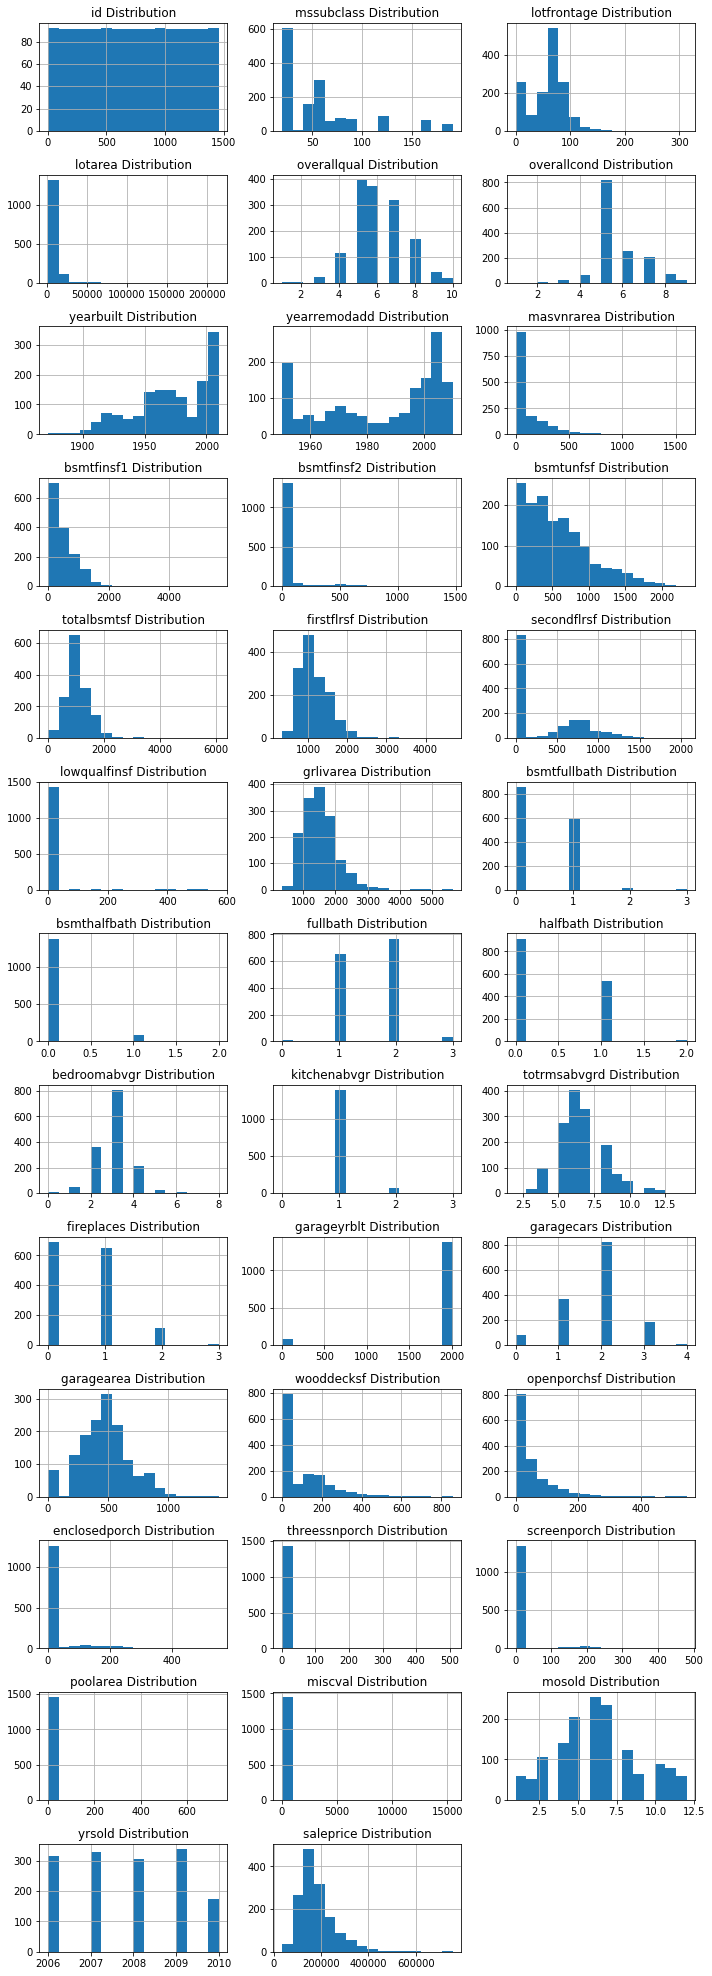

In [26]:
# Univariate visualization without having to manually plot each graph

def draw_histograms(df, columns, n_rows, n_cols):
    fig=plt.figure(figsize =(10, 80))
    for i, var_name in enumerate(columns):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=16,ax=ax)
        ax.set_title(var_name + " Distribution")
        
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()
    
draw_histograms(df_houseprices2, num_cols, len(num_cols), 3)

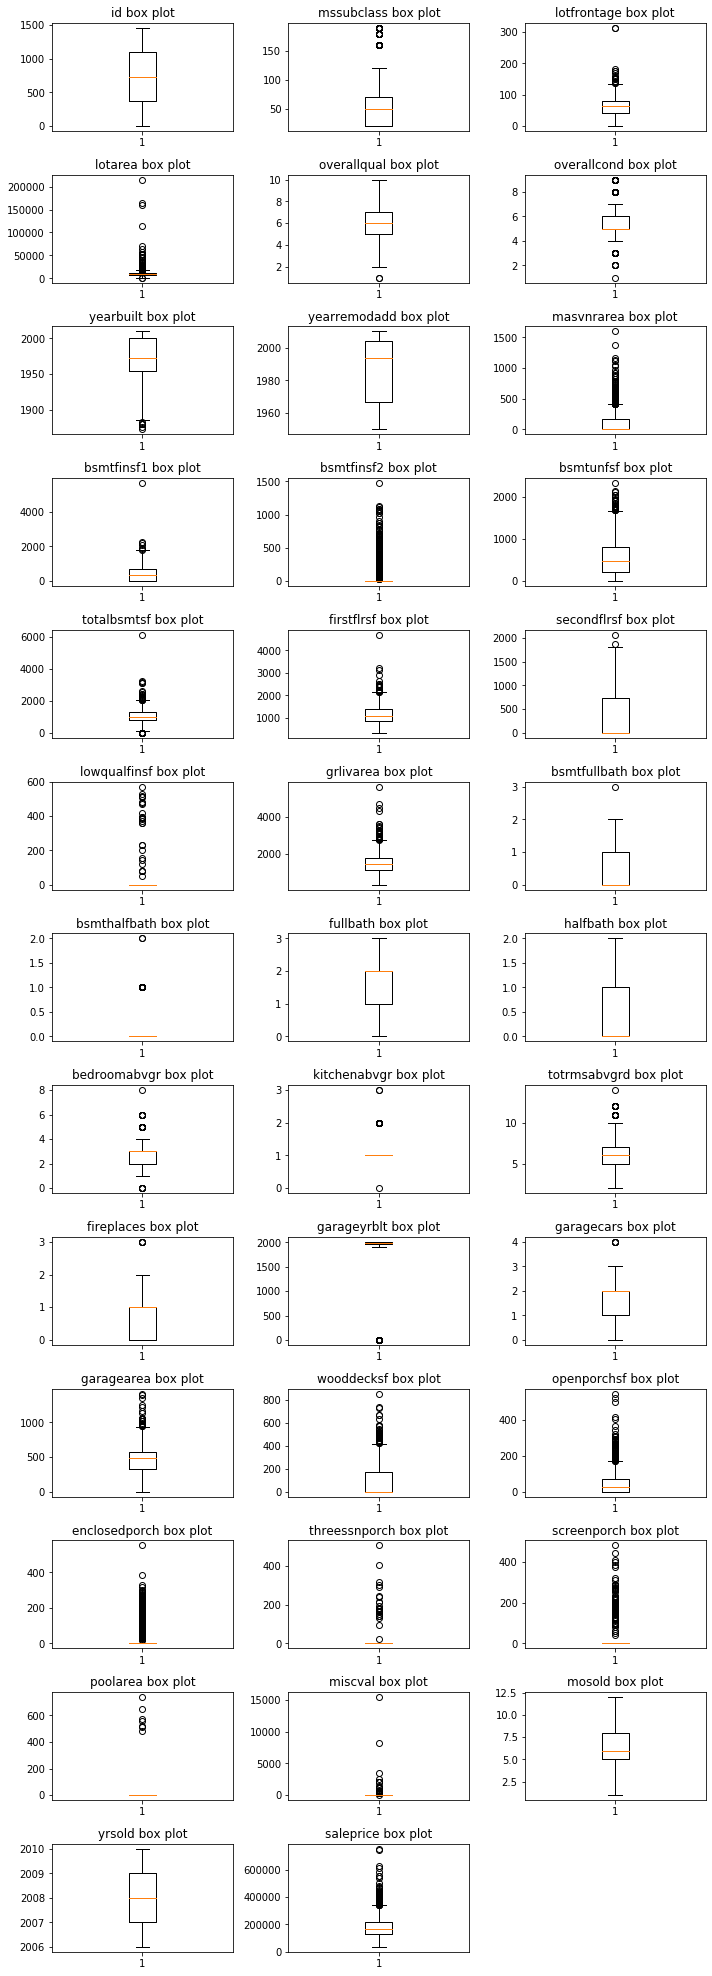

In [27]:
# box plots of to viualize outliers

def draw_box(df, columns, n_rows, n_cols):
    fig=plt.figure(figsize =(10, 80))
    for i, var_name in enumerate(columns):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        ax.boxplot(df[var_name])
        ax.set_title(var_name + ' box plot')
    fig.tight_layout()
    plt.show()
    
draw_box(df_houseprices2, num_cols, len(num_cols), 3)

In [28]:
# Calculate number of outliers and its percentage in each variable using Tukey's method.

for variable in num_cols:
    q75, q25 = np.percentile(df_houseprices2[variable], [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers and percentage of it in {} : {} and {}".format(variable,
                                                                             len((np.where((df_houseprices2[variable] > max_val) | 
                                                                                           (df_houseprices2[variable] < min_val))[0])),len((np.where((df_houseprices2[variable] > max_val) | 
                                                                                           (df_houseprices2[variable] < min_val))[0]))*100/1987))

Number of outliers and percentage of it in id : 0 and 0.0
Number of outliers and percentage of it in mssubclass : 103 and 5.183694011071967
Number of outliers and percentage of it in lotfrontage : 16 and 0.8052340211373931
Number of outliers and percentage of it in lotarea : 69 and 3.4725717161550076
Number of outliers and percentage of it in overallqual : 2 and 0.10065425264217413
Number of outliers and percentage of it in overallcond : 125 and 6.290890790135883
Number of outliers and percentage of it in yearbuilt : 7 and 0.3522898842476095
Number of outliers and percentage of it in yearremodadd : 0 and 0.0
Number of outliers and percentage of it in masvnrarea : 98 and 4.9320583794665325
Number of outliers and percentage of it in bsmtfinsf1 : 7 and 0.3522898842476095
Number of outliers and percentage of it in bsmtfinsf2 : 167 and 8.40463009562154
Number of outliers and percentage of it in bsmtunfsf : 29 and 1.4594866633115249
Number of outliers and percentage of it in totalbsmtsf : 61

Removing only the outliers on variables where the data makes sense to do so. If we normalize everything, then we run the risk of losing integrity of the data because many homes simply will not have the same feature sets as others. Also, some variables have a very few inputs and the majority of the data is 0. Removing assumed outliers without considering these implications can remove possibly helpful features. 

In [29]:
df_houseprices3 = df_houseprices2.copy()

In [30]:
df_houseprices3.head()

id  mssubclass mszoning  lotfrontage  lotarea street alley lotshape  \
0   1          60       RL       65.000     8450   Pave  NONE      Reg   
1   2          20       RL       80.000     9600   Pave  NONE      Reg   
2   3          60       RL       68.000    11250   Pave  NONE      IR1   
3   4          70       RL       60.000     9550   Pave  NONE      IR1   
4   5          60       RL       84.000    14260   Pave  NONE      IR1   

  landcontour utilities lotconfig landslope neighborhood condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  condition2 bldgtype housestyle  overallqual  overallcond  yearbuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   yearremodadd roofstyle roofmatl exterior1st exterior2nd masvnrtype  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   masvnrarea exterqual extercond foundation bsmtqual bsmtcond bsmtexposure  \
0     196.000        Gd        TA      PConc       Gd       TA           No   
1       0.000        TA        TA     CBlock       Gd       TA           Gd   
2     162.000        Gd        TA      PConc       Gd       TA           Mn   
3       0.000        TA        TA     BrkTil       TA       Gd           No   
4     350.000        Gd        TA      PConc       Gd       TA           Av   

  bsmtfintype1  bsmtfinsf1 bsmtfintype2  bsmtfinsf2  bsmtunfsf  totalbsmtsf  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  heating heatingqc centralair electrical  firstflrsf  secondflrsf  \
0    GasA        Ex          Y      SBrkr         856          854   
1    GasA        Ex          Y      SBrkr        1262            0   
2    GasA        Ex          Y      SBrkr         920          866   
3    GasA        Gd          Y      SBrkr         961          756   
4    GasA        Ex          Y      SBrkr        1145         1053   

   lowqualfinsf  grlivarea  bsmtfullbath  bsmthalfbath  fullbath  halfbath  \
0             0       1710             1             0         2         1   
1             0       1262             0             1         2         0   
2             0       1786             1             0         2         1   
3             0       1717             1             0         1         0   
4             0       2198             1             0         2         1   

   bedroomabvgr  kitchenabvgr kitchenqual  totrmsabvgrd functional  \
0             3             1          Gd             8        Typ   
1             3             1          TA             6        Typ   
2             3             1          Gd             6        Typ   
3             3             1          Gd             7        Typ   
4             4             1          Gd             9        

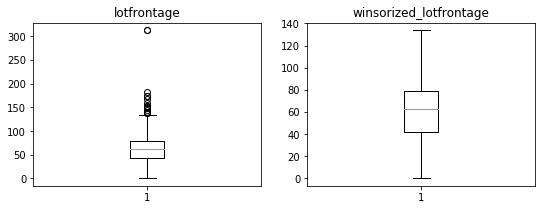

In [31]:
# Removing Outliers in the variables using Winsorization technique.
#Winsorize lotfrontage
plt.figure(figsize=(9,3))

plt.subplot(1,2,1)
original_lotfrontage = df_houseprices3['lotfrontage']
plt.boxplot(original_lotfrontage)
plt.title("lotfrontage")

plt.subplot(1,2,2)
df_houseprices3['lotfrontage'] = winsorize(df_houseprices3['lotfrontage'], (0.00, 0.011))
winsorized_df_houseprices3 = df_houseprices3['lotfrontage']
plt.boxplot(df_houseprices3['lotfrontage'])
plt.title("winsorized_lotfrontage")

plt.show()

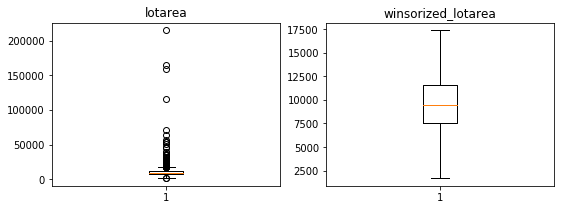

In [32]:
# Removing Outliers in the variables using Winsorization technique.
#Winsorize lotarea
plt.figure(figsize=(9,3))

plt.subplot(1,2,1)
original_lotarea = df_houseprices3['lotarea']
plt.boxplot(original_lotarea)
plt.title("lotarea")

plt.subplot(1,2,2)
df_houseprices3['lotarea'] = winsorize(df_houseprices3['lotarea'], (0.005, 0.05))
winsorized_df_houseprices3 = df_houseprices3['lotarea']
plt.boxplot(df_houseprices3['lotarea'])
plt.title("winsorized_lotarea")

plt.show()

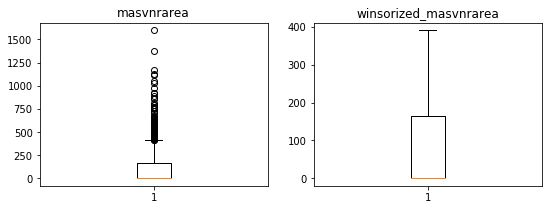

In [33]:
# Removing Outliers in the variables using Winsorization technique.
#Winsorize masvnrarea
plt.figure(figsize=(9,3))

plt.subplot(1,2,1)
original_masvnrarea = df_houseprices3['masvnrarea']
plt.boxplot(original_masvnrarea)
plt.title("masvnrarea")

plt.subplot(1,2,2)
df_houseprices3['masvnrarea'] = winsorize(df_houseprices3['masvnrarea'], (0.00, 0.07))
winsorized_df_houseprices3 = df_houseprices3['masvnrarea']
plt.boxplot(df_houseprices3['masvnrarea'])
plt.title("winsorized_masvnrarea")

plt.show()

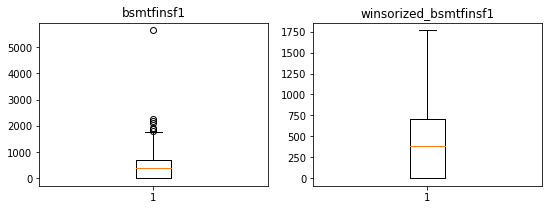

In [34]:
# Removing Outliers in the variables using Winsorization technique.
#Winsorize bsmtfinsf1
plt.figure(figsize=(9,3))

plt.subplot(1,2,1)
original_bsmtfinsf1 = df_houseprices3['bsmtfinsf1']
plt.boxplot(original_bsmtfinsf1)
plt.title("bsmtfinsf1")

plt.subplot(1,2,2)
df_houseprices3['bsmtfinsf1'] = winsorize(df_houseprices3['bsmtfinsf1'], (0.00, 0.005))
winsorized_df_houseprices3 = df_houseprices3['bsmtfinsf1']
plt.boxplot(df_houseprices3['bsmtfinsf1'])
plt.title("winsorized_bsmtfinsf1")

plt.show()

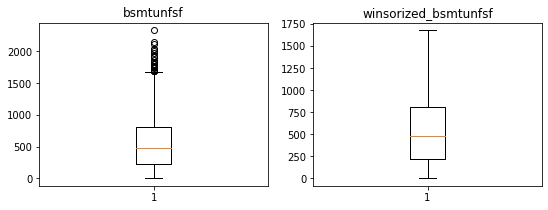

In [35]:
# Removing Outliers in the variables using Winsorization technique.
#Winsorize bsmtunfsf
plt.figure(figsize=(9,3))

plt.subplot(1,2,1)
original_bsmtunfsf = df_houseprices3['bsmtunfsf']
plt.boxplot(original_bsmtunfsf)
plt.title("bsmtunfsf")

plt.subplot(1,2,2)
df_houseprices3['bsmtunfsf'] = winsorize(df_houseprices3['bsmtunfsf'], (0.00, 0.02))
winsorized_df_houseprices3 = df_houseprices3['bsmtunfsf']
plt.boxplot(df_houseprices3['bsmtunfsf'])
plt.title("winsorized_bsmtunfsf")

plt.show()

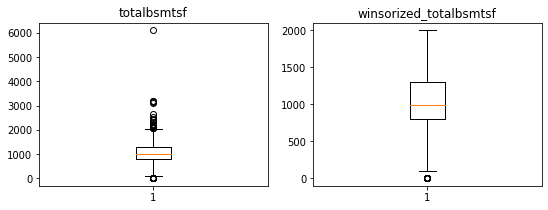

In [36]:
# Removing Outliers in the variables using Winsorization technique.
#Winsorize totalbsmtsf
plt.figure(figsize=(9,3))

plt.subplot(1,2,1)
original_totalbsmtsf = df_houseprices3['totalbsmtsf']
plt.boxplot(original_totalbsmtsf)
plt.title("totalbsmtsf")

plt.subplot(1,2,2)
df_houseprices3['totalbsmtsf'] = winsorize(df_houseprices3['totalbsmtsf'], (0.00, 0.02)) # leave the zero values as is.
winsorized_df_houseprices3 = df_houseprices3['totalbsmtsf']
plt.boxplot(df_houseprices3['totalbsmtsf'])
plt.title("winsorized_totalbsmtsf")

plt.show()

I left the zeros in the data because that represents the homes without any basements.

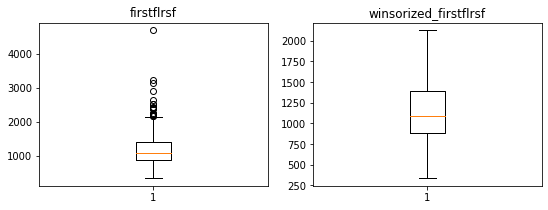

In [37]:
# Removing Outliers in the variables using Winsorization technique.
#Winsorize firstflrsf
plt.figure(figsize=(9,3))

plt.subplot(1,2,1)
original_firstflrsf = df_houseprices3['firstflrsf']
plt.boxplot(original_firstflrsf)
plt.title("firstflrsf")

plt.subplot(1,2,2)
df_houseprices3['firstflrsf'] = winsorize(df_houseprices3['firstflrsf'], (0.00, 0.015))
winsorized_df_houseprices3 = df_houseprices3['firstflrsf']
plt.boxplot(df_houseprices3['firstflrsf'])
plt.title("winsorized_firstflrsf")

plt.show()

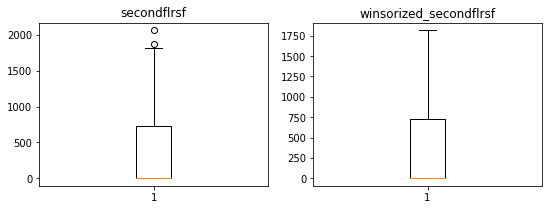

In [38]:
# Removing Outliers in the variables using Winsorization technique.
#Winsorize secondflrsf
plt.figure(figsize=(9,3))

plt.subplot(1,2,1)
original_secondflrsf = df_houseprices3['secondflrsf']
plt.boxplot(original_secondflrsf)
plt.title("secondflrsf")

plt.subplot(1,2,2)
df_houseprices3['secondflrsf'] = winsorize(df_houseprices3['secondflrsf'], (0.00, 0.002))
winsorized_df_houseprices3 = df_houseprices3['secondflrsf']
plt.boxplot(df_houseprices3['secondflrsf'])
plt.title("winsorized_secondflrsf")

plt.show()

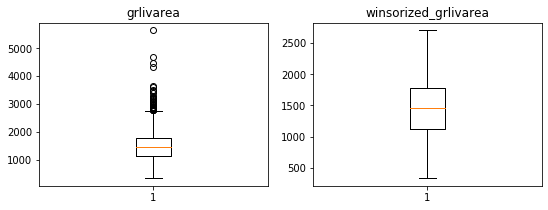

In [39]:
# Removing Outliers in the variables using Winsorization technique.
#Winsorize grlivarea
plt.figure(figsize=(9,3))

plt.subplot(1,2,1)
original_grlivarea = df_houseprices3['grlivarea']
plt.boxplot(original_grlivarea)
plt.title("grlivarea")

plt.subplot(1,2,2)
df_houseprices3['grlivarea'] = winsorize(df_houseprices3['grlivarea'], (0.00, 0.025))
winsorized_df_houseprices3 = df_houseprices3['grlivarea']
plt.boxplot(df_houseprices3['grlivarea'])
plt.title("winsorized_grlivarea")

plt.show()

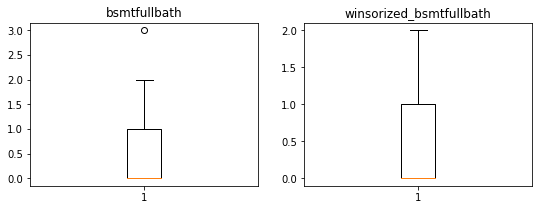

In [40]:
# Removing Outliers in the variables using Winsorization technique.
#Winsorize bsmtfullbath
plt.figure(figsize=(9,3))

plt.subplot(1,2,1)
original_bsmtfullbath = df_houseprices3['bsmtfullbath']
plt.boxplot(original_bsmtfullbath)
plt.title("bsmtfullbath")

plt.subplot(1,2,2)
df_houseprices3['bsmtfullbath'] = winsorize(df_houseprices3['bsmtfullbath'], (0.00, 0.001))
winsorized_df_houseprices3 = df_houseprices3['bsmtfullbath']
plt.boxplot(df_houseprices3['bsmtfullbath'])
plt.title("winsorized_bsmtfullbath")

plt.show()

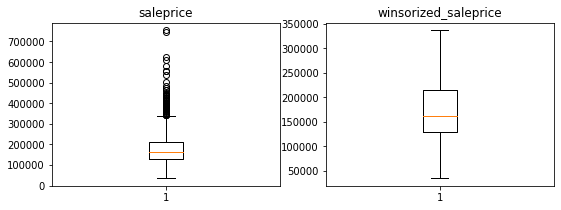

In [41]:
# Removing Outliers in the variables using Winsorization technique.
#Winsorize saleprice
plt.figure(figsize=(9,3))

plt.subplot(1,2,1)
original_saleprice = df_houseprices3['saleprice']
plt.boxplot(original_saleprice)
plt.title("saleprice")

plt.subplot(1,2,2)
df_houseprices3['winsorized_saleprice'] = winsorize(df_houseprices3['saleprice'], (0.00, 0.045))
winsorized_df_houseprices3 = df_houseprices3['winsorized_saleprice']
plt.boxplot(df_houseprices3['winsorized_saleprice'])
plt.title("winsorized_saleprice")

plt.show()

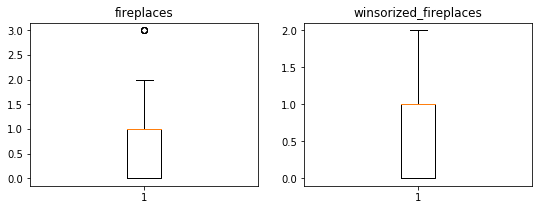

In [42]:
# Removing Outliers in the variables using Winsorization technique.
#Winsorize fireplaces
plt.figure(figsize=(9,3))

plt.subplot(1,2,1)
original_fireplaces = df_houseprices3['fireplaces']
plt.boxplot(original_fireplaces)
plt.title("fireplaces")

plt.subplot(1,2,2)
df_houseprices3['fireplaces'] = winsorize(df_houseprices3['fireplaces'], (0.00, 0.004))
winsorized_df_houseprices3 = df_houseprices3['fireplaces']
plt.boxplot(df_houseprices3['fireplaces'])
plt.title("winsorized_fireplaces")

plt.show()

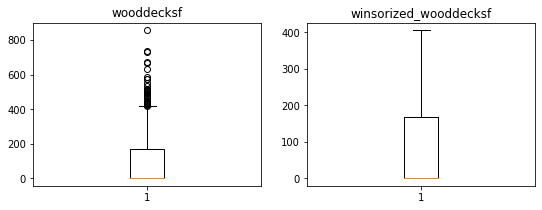

In [43]:
# Removing Outliers in the variables using Winsorization technique.
#Winsorize wooddecksf
plt.figure(figsize=(9,3))

plt.subplot(1,2,1)
original_wooddecksf = df_houseprices3['wooddecksf']
plt.boxplot(original_wooddecksf)
plt.title("wooddecksf")

plt.subplot(1,2,2)
df_houseprices3['wooddecksf'] = winsorize(df_houseprices3['wooddecksf'], (0.00, 0.025))
winsorized_df_houseprices3 = df_houseprices3['wooddecksf']
plt.boxplot(df_houseprices3['wooddecksf'])
plt.title("winsorized_wooddecksf")

plt.show()

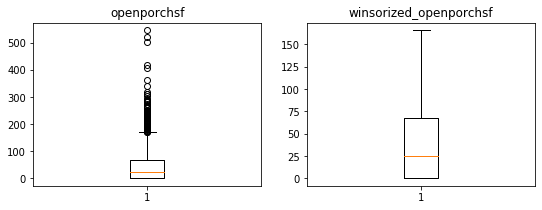

In [44]:
# Removing Outliers in the variables using Winsorization technique.
#Winsorize openporchsf
plt.figure(figsize=(9,3))

plt.subplot(1,2,1)
original_openporchsf = df_houseprices3['openporchsf']
plt.boxplot(original_openporchsf)
plt.title("openporchsf")

plt.subplot(1,2,2)
df_houseprices3['openporchsf'] = winsorize(df_houseprices3['openporchsf'], (0.00, 0.06))
winsorized_df_houseprices3 = df_houseprices3['openporchsf']
plt.boxplot(df_houseprices3['openporchsf'])
plt.title("winsorized_openporchsf")

plt.show()

In [45]:
# Calculate number of outliers and its percentage in each variable using Tukey's method.

for variable in num_cols:
    q75, q25 = np.percentile(df_houseprices2[variable], [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers and percentage of it in {} : {} and {}".format(variable,
                                                                             len((np.where((df_houseprices2[variable] > max_val) | 
                                                                                           (df_houseprices2[variable] < min_val))[0])),len((np.where((df_houseprices2[variable] > max_val) | 
                                                                                           (df_houseprices2[variable] < min_val))[0]))*100/1987))

Number of outliers and percentage of it in id : 0 and 0.0
Number of outliers and percentage of it in mssubclass : 103 and 5.183694011071967
Number of outliers and percentage of it in lotfrontage : 16 and 0.8052340211373931
Number of outliers and percentage of it in lotarea : 69 and 3.4725717161550076
Number of outliers and percentage of it in overallqual : 2 and 0.10065425264217413
Number of outliers and percentage of it in overallcond : 125 and 6.290890790135883
Number of outliers and percentage of it in yearbuilt : 7 and 0.3522898842476095
Number of outliers and percentage of it in yearremodadd : 0 and 0.0
Number of outliers and percentage of it in masvnrarea : 98 and 4.9320583794665325
Number of outliers and percentage of it in bsmtfinsf1 : 7 and 0.3522898842476095
Number of outliers and percentage of it in bsmtfinsf2 : 167 and 8.40463009562154
Number of outliers and percentage of it in bsmtunfsf : 29 and 1.4594866633115249
Number of outliers and percentage of it in totalbsmtsf : 61

In [46]:
# Descriptive statistics of categorical variables.
df_houseprices3.describe(include='all')

id  mssubclass mszoning  lotfrontage   lotarea street alley  \
count  1460.000    1460.000     1460     1460.000  1460.000   1460  1460   
unique      nan         nan        5          nan       nan      2     3   
top         nan         nan       RL          nan       nan   Pave  NONE   
freq        nan         nan     1151          nan       nan   1454  1369   
mean    730.500      56.897      NaN       57.182  9635.028    NaN   NaN   
std     421.610      42.301      NaN       32.926  3563.665    NaN   NaN   
min       1.000      20.000      NaN        0.000  1680.000    NaN   NaN   
25%     365.750      20.000      NaN       42.000  7553.500    NaN   NaN   
50%     730.500      50.000      NaN       63.000  9478.500    NaN   NaN   
75%    1095.250      70.000      NaN       79.000 11601.500    NaN   NaN   
max    1460.000     190.000      NaN      134.000 17400.000    NaN   NaN   

       lotshape landcontour utilities lotconfig landslope neighborhood  \
count      1460        1460      1460      1460      1460         1460   
unique        4           4         2         5         3           25   
top         Reg         Lvl    AllPub    Inside       Gtl        NAmes   
freq        925        1311      1459      1052      1382          225   
mean        NaN         NaN       NaN       NaN       NaN          NaN   
std         NaN         NaN       NaN       NaN       NaN          NaN   
min         NaN         NaN       NaN       NaN       NaN          NaN   
25%         NaN         NaN       NaN       NaN       NaN          NaN   
50%         NaN         NaN       NaN       NaN       NaN          NaN   
75%         NaN         NaN       NaN       NaN       NaN          NaN   
max         NaN         NaN       NaN       NaN       NaN          NaN   

       condition1 condition2 bldgtype housestyle  overallqual  overallcond  \
count        1460       1460     1460       1460     1460.000     1460.000   
unique          9          8        5          8          nan          nan   
top          Norm       Norm     1Fam     1Story          nan          nan   
freq         1260       1445     1220        726          nan          nan   
mean          NaN        NaN      NaN        NaN        6.099        5.575   
std           NaN        NaN      NaN        NaN        1.383        1.113   
min           NaN        NaN      NaN        NaN        1.000        1.000   
25%           NaN        NaN      NaN        NaN        5.000        5.000   
50%           NaN        NaN      NaN        NaN        6.000        5.000   
75%           NaN        NaN      NaN        NaN        7.000        6.000   
max           NaN        NaN      NaN        NaN       10.000        9.000   

        yearbuilt  yearremodadd roofstyle roofmatl exterior1st exterior2nd  \
count    1460.000      1460.000      1460     1460        1460        1460   
unique        nan           nan         6        8          15          16   
top           nan           nan     Gable  CompShg     VinylSd     VinylSd   
freq          nan           nan      1141     1434         515         504   
mean     1971.268      1984.866       NaN      NaN         NaN         NaN   
std        30.203        20.645       NaN      NaN         NaN         NaN   
min      1872.000      1950.000       NaN      NaN         NaN         NaN   
25%      1954.000      1967.000       NaN      NaN         NaN         NaN   
50%      1973.000      1994.000       NaN      NaN         NaN         NaN   
75%      2000.000      2004.000       NaN      NaN         NaN         NaN   
max      2010.000      2010.000       NaN      NaN         NaN         NaN   

       masvnrtype  masvnrarea exterqual extercond foundation bsmtqual  \
count        1460    1460.000      1460      1460       1460     1460   
unique          5         nan         4         5          6        5   
top          None         nan        TA        TA      PConc       TA   
freq          864         nan       906      

In [47]:
# new numeric column list
num_cols_2 = df_houseprices3.select_dtypes(['int64', 'float64']).columns.copy()

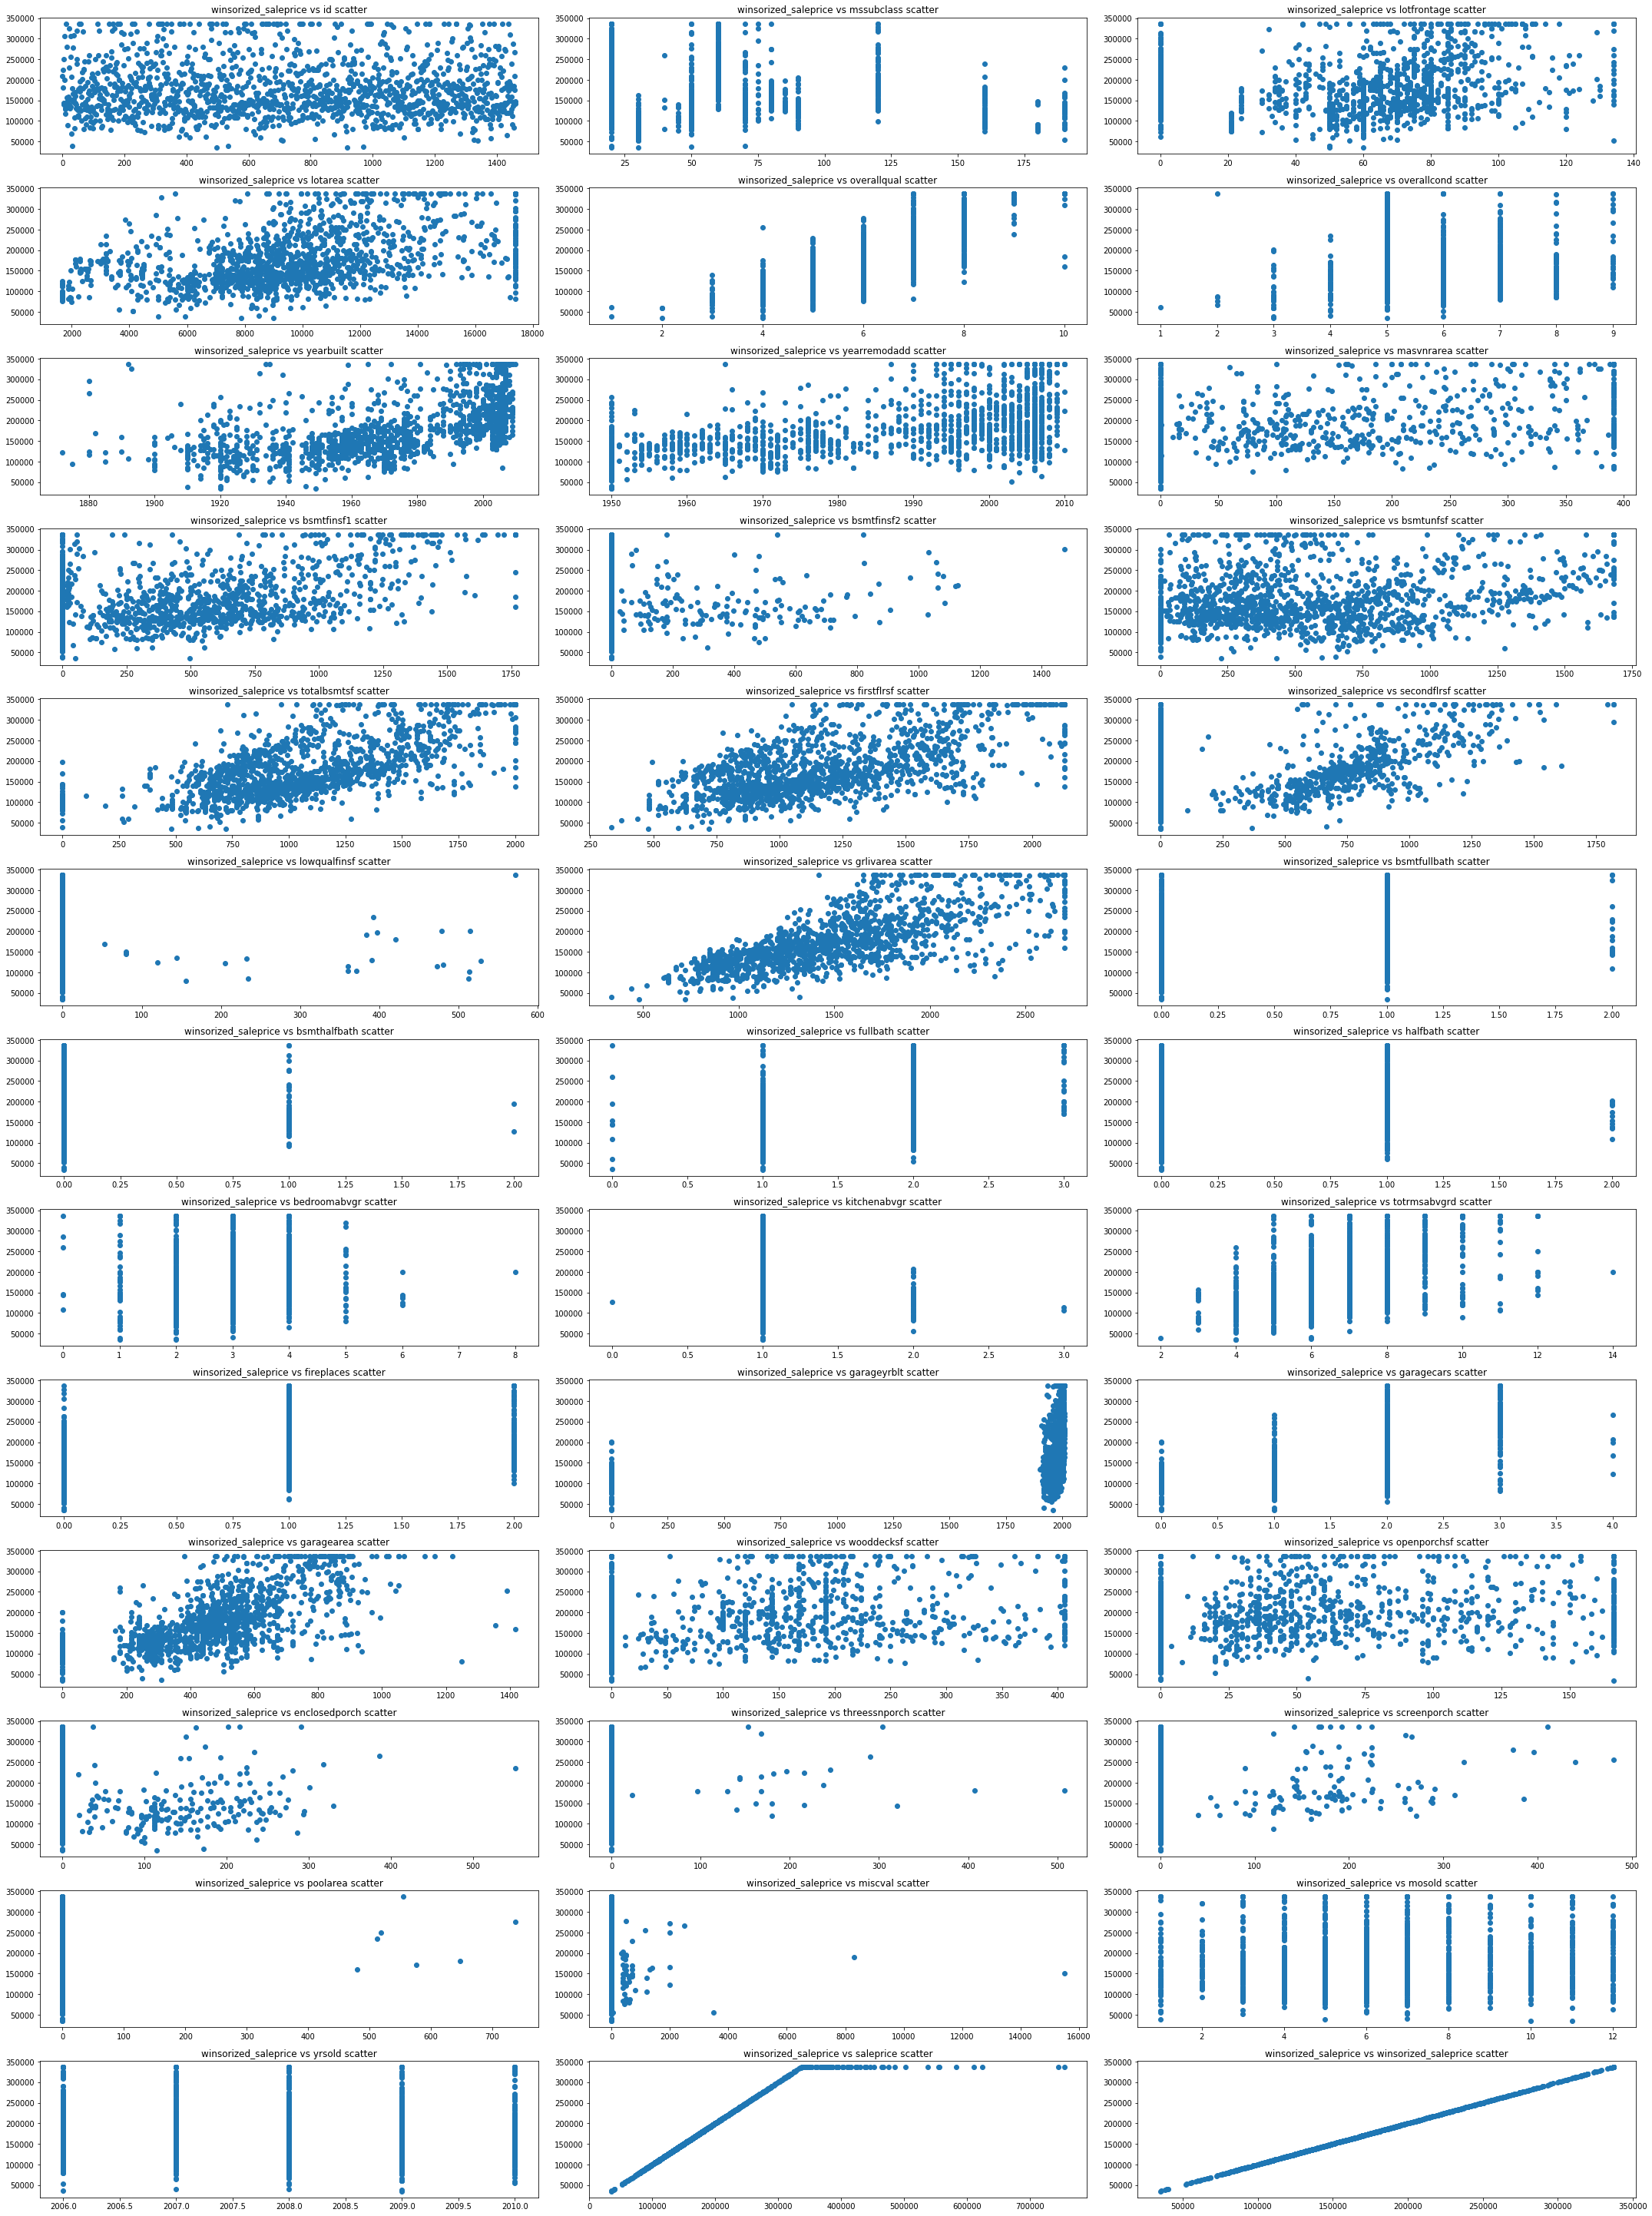

In [48]:
def draw_scatter(df, columns, n_rows, n_cols):
    fig=plt.figure(figsize = (30,120))
    for i, var_name in enumerate(columns):
        ax=fig.add_subplot(n_rows, n_cols, i+1)
        ax.scatter(df[var_name], df['winsorized_saleprice'])
        ax.set_title('winsorized_saleprice vs ' + str(var_name) + " scatter")
    fig.tight_layout()
    plt.show()
    
draw_scatter(df_houseprices3, num_cols_2, len(num_cols_2), 3)

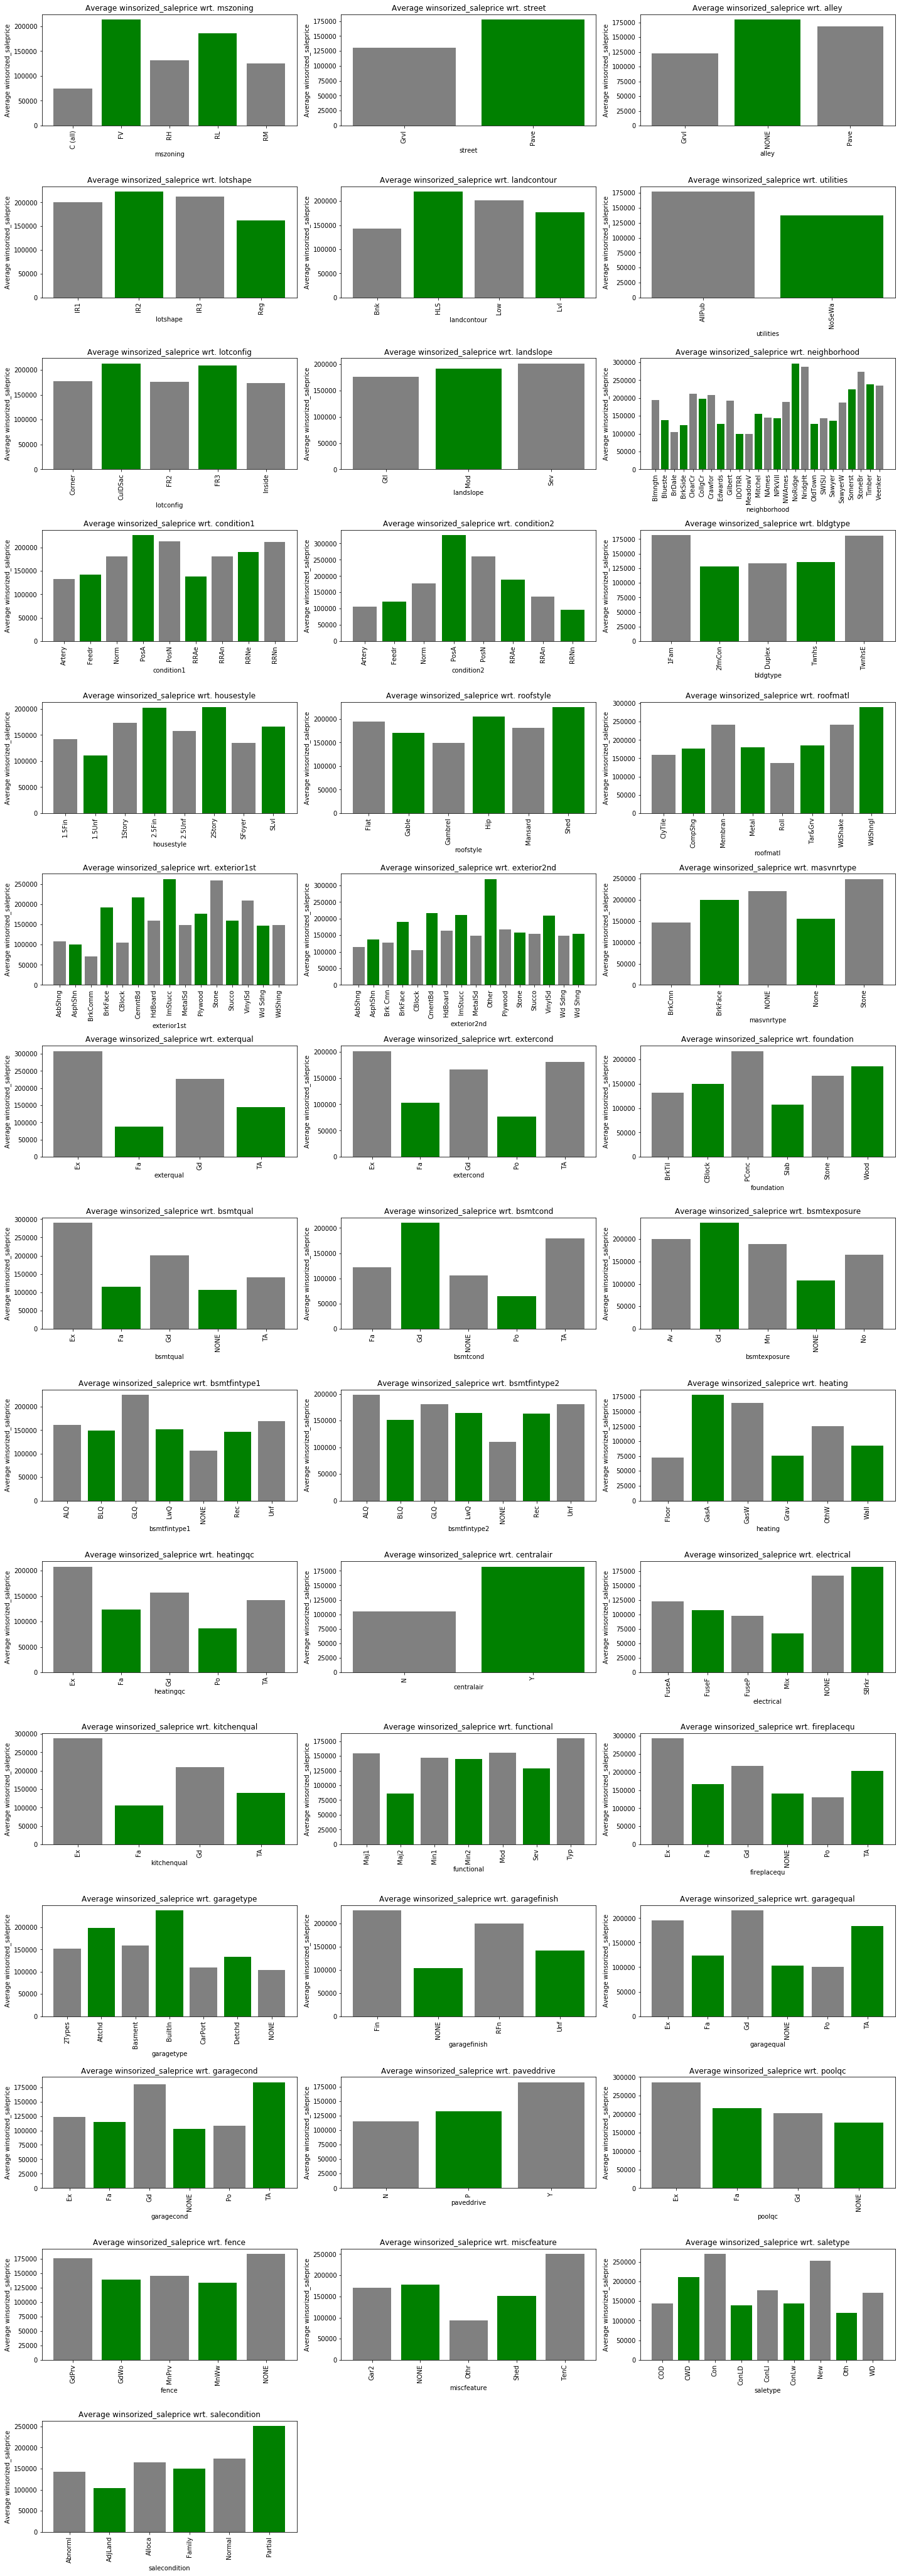

In [49]:
plt.figure(figsize=(20,60))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(16,3,index+1)
    plt.bar(df_houseprices3.groupby(column)["winsorized_saleprice"].mean().index, df_houseprices3.groupby(column)["winsorized_saleprice"].mean(),
           color=("grey","green"))
    plt.title("Average winsorized_saleprice wrt. {}".format(column))
    plt.ylabel("Average winsorized_saleprice")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

In [50]:
df_houseprices3.head()

id  mssubclass mszoning  lotfrontage  lotarea street alley lotshape  \
0   1          60       RL       65.000     8450   Pave  NONE      Reg   
1   2          20       RL       80.000     9600   Pave  NONE      Reg   
2   3          60       RL       68.000    11250   Pave  NONE      IR1   
3   4          70       RL       60.000     9550   Pave  NONE      IR1   
4   5          60       RL       84.000    14260   Pave  NONE      IR1   

  landcontour utilities lotconfig landslope neighborhood condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  condition2 bldgtype housestyle  overallqual  overallcond  yearbuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   yearremodadd roofstyle roofmatl exterior1st exterior2nd masvnrtype  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   masvnrarea exterqual extercond foundation bsmtqual bsmtcond bsmtexposure  \
0     196.000        Gd        TA      PConc       Gd       TA           No   
1       0.000        TA        TA     CBlock       Gd       TA           Gd   
2     162.000        Gd        TA      PConc       Gd       TA           Mn   
3       0.000        TA        TA     BrkTil       TA       Gd           No   
4     350.000        Gd        TA      PConc       Gd       TA           Av   

  bsmtfintype1  bsmtfinsf1 bsmtfintype2  bsmtfinsf2  bsmtunfsf  totalbsmtsf  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  heating heatingqc centralair electrical  firstflrsf  secondflrsf  \
0    GasA        Ex          Y      SBrkr         856          854   
1    GasA        Ex          Y      SBrkr        1262            0   
2    GasA        Ex          Y      SBrkr         920          866   
3    GasA        Gd          Y      SBrkr         961          756   
4    GasA        Ex          Y      SBrkr        1145         1053   

   lowqualfinsf  grlivarea  bsmtfullbath  bsmthalfbath  fullbath  halfbath  \
0             0       1710             1             0         2         1   
1             0       1262             0             1         2         0   
2             0       1786             1             0         2         1   
3             0       1717             1             0         1         0   
4             0       2198             1             0         2         1   

   bedroomabvgr  kitchenabvgr kitchenqual  totrmsabvgrd functional  \
0             3             1          Gd             8        Typ   
1             3             1          TA             6        Typ   
2             3             1          Gd             6        Typ   
3             3             1          Gd             7        Typ   
4             4             1          Gd             9        

### Adding Features

In [51]:
# total square feet of the home: main house + basement
df_houseprices3['totalsf'] = df_houseprices3['totalbsmtsf'] + df_houseprices3['firstflrsf'] + df_houseprices3['secondflrsf']

# combining quality and total square feet to give weight to nice, small homes vs poor, large homes
df_houseprices3['totalsf_qual'] = df_houseprices3['totalsf'] * df_houseprices3['overallqual']

# determining IF a house was actually remodeled. Not the same as age of the home, so this can hopefully be another distinguising factor.
# changed the boolean to 1 and 0 to keep the dataframe homogenous with other boolean columns.
df_houseprices3['was_remodeled'] = ((df_houseprices3['yearremodadd'] - df_houseprices3['yearbuilt']) > 0).astype('int64')

# avoiding complexities with datetime, multiplying yrsold and mosold will combine both values into 1 column
df_houseprices3['numeric_dates'] = df_houseprices3['yrsold'] * df_houseprices3['mosold']

In [52]:
# new numeric column list
num_cols_3 = [col_name for col_name in df_houseprices3.select_dtypes(['int64', 'float64']).columns.copy()
              if col_name not in ["id", "winsorized_saleprice"]]
num_cols_3

['mssubclass',
 'lotfrontage',
 'lotarea',
 'overallqual',
 'overallcond',
 'yearbuilt',
 'yearremodadd',
 'masvnrarea',
 'bsmtfinsf1',
 'bsmtfinsf2',
 'bsmtunfsf',
 'totalbsmtsf',
 'firstflrsf',
 'secondflrsf',
 'lowqualfinsf',
 'grlivarea',
 'bsmtfullbath',
 'bsmthalfbath',
 'fullbath',
 'halfbath',
 'bedroomabvgr',
 'kitchenabvgr',
 'totrmsabvgrd',
 'fireplaces',
 'garageyrblt',
 'garagecars',
 'garagearea',
 'wooddecksf',
 'openporchsf',
 'enclosedporch',
 'threessnporch',
 'screenporch',
 'poolarea',
 'miscval',
 'mosold',
 'yrsold',
 'saleprice',
 'totalsf',
 'totalsf_qual',
 'was_remodeled',
 'numeric_dates']

### Continuous Variable Selection

In [53]:
df_hp = df_houseprices3.copy()

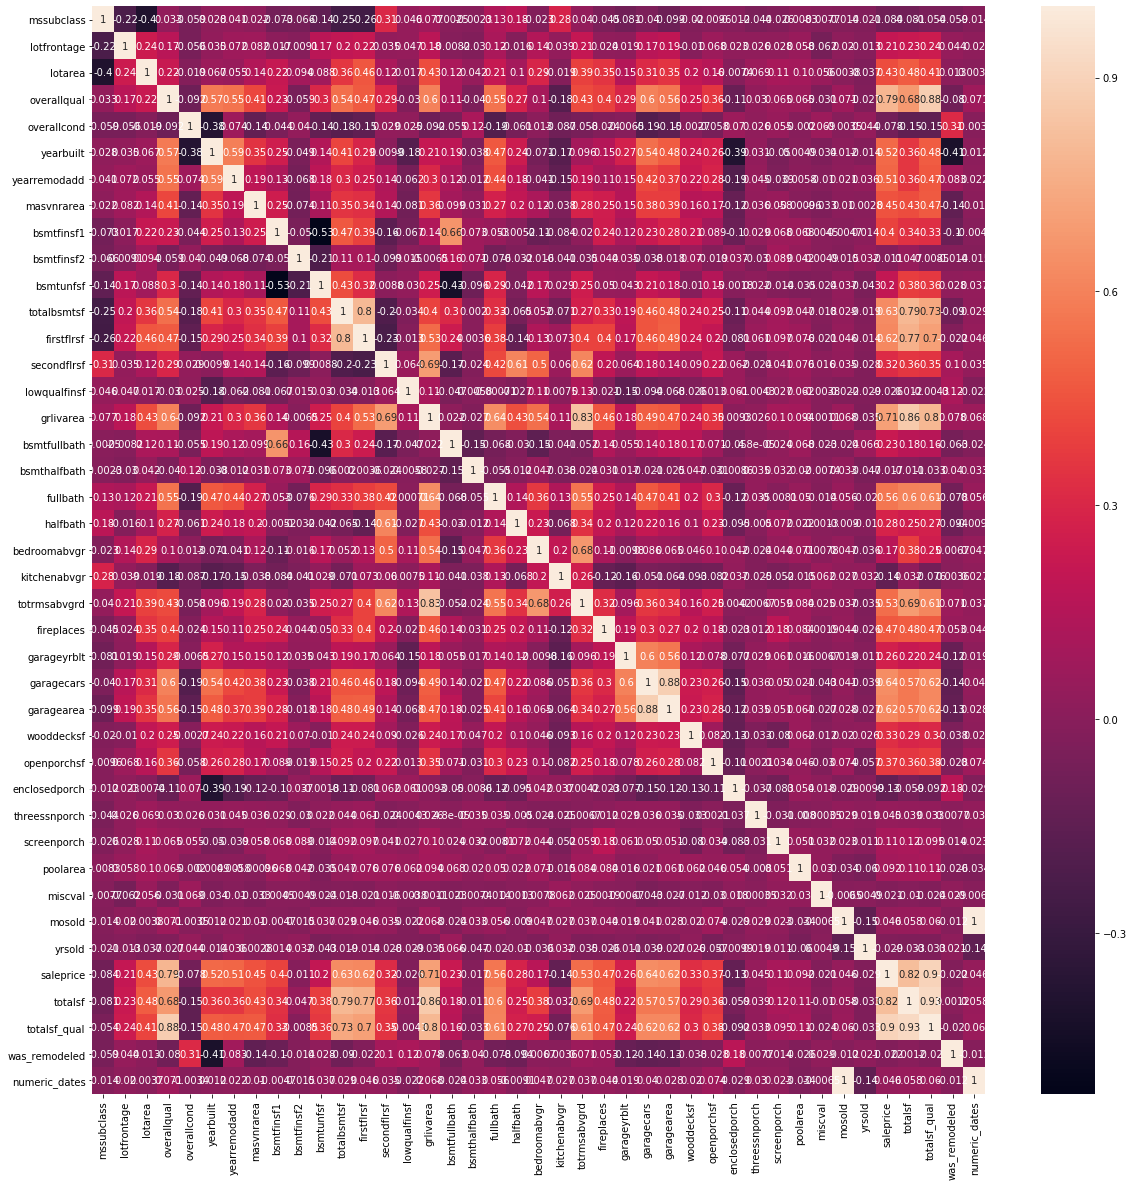

In [54]:
# See the correlation heatmap of the features
plt.figure(figsize=(20,20))
sns.heatmap(df_hp[num_cols_3].corr(),annot=True)

In [55]:
# Comparing correlation strength with "SalePrice", sorted on correlation value.
# NOTE: None of the variables have a strong negative relationship with "SalePrice"
num_corr = abs(df_hp[df_hp.columns[1:]].corr()['winsorized_saleprice'][:]).sort_values()
print(num_corr)

bsmtfinsf2             0.008
miscval                0.020
bsmthalfbath           0.027
yrsold                 0.031
lowqualfinsf           0.040
was_remodeled          0.044
threessnporch          0.050
poolarea               0.056
numeric_dates          0.068
mosold                 0.068
overallcond            0.075
mssubclass             0.085
screenporch            0.109
enclosedporch          0.140
kitchenabvgr           0.150
bedroomabvgr           0.182
lotfrontage            0.195
bsmtunfsf              0.216
bsmtfullbath           0.241
garageyrblt            0.294
halfbath               0.295
secondflrsf            0.317
wooddecksf             0.345
bsmtfinsf1             0.387
openporchsf            0.397
lotarea                0.437
masvnrarea             0.449
fireplaces             0.489
totrmsabvgrd           0.529
yearremodadd           0.553
yearbuilt              0.570
fullbath               0.585
firstflrsf             0.622
totalbsmtsf            0.643
garagearea    

In [56]:
lower_corr_df = pd.DataFrame(num_corr)
lower_corr_df.columns = ['CorrelationSalePrice']

# make drop list
to_drop = lower_corr_df[lower_corr_df['CorrelationSalePrice'] < 0.2].index

# Drop features 
df_hp_2 = df_hp.drop(to_drop, axis=1)

In [57]:
# new numeric column list
num_cols_4 = [col_name for col_name in df_hp_2.select_dtypes(['int64', 'float64']).columns.copy()
              if col_name not in ["id", "winsorized_saleprice"]]

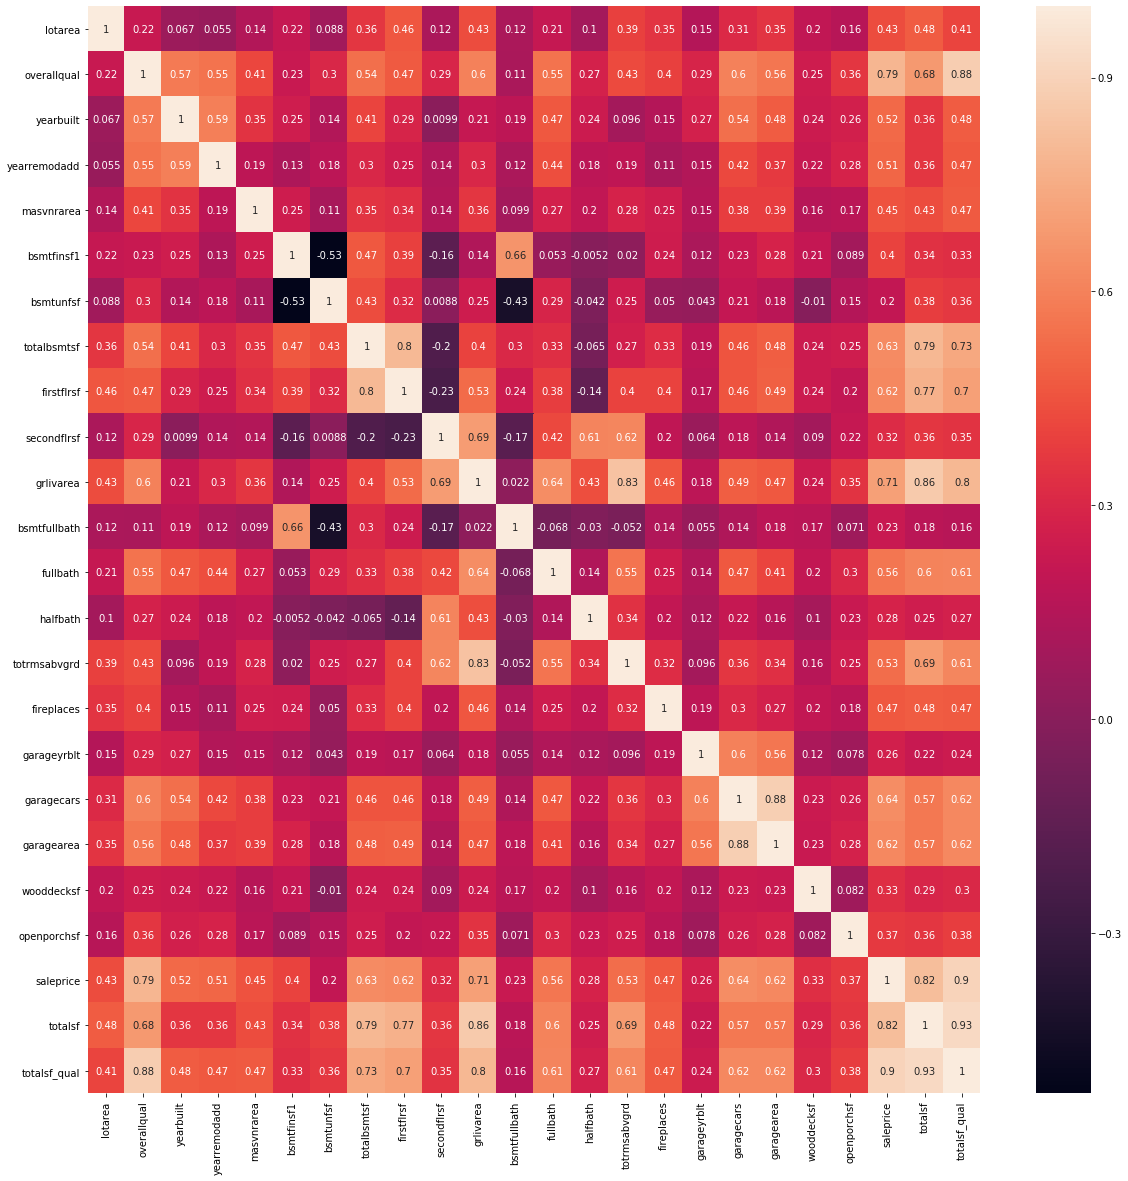

In [58]:
# See the correlation heatmap of the features
plt.figure(figsize=(20,20))
sns.heatmap(df_hp_2[num_cols_4].corr(),annot=True)

In [59]:
# Create correlation matrix
corr_matrix = df_hp_2[num_cols_4].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

# Drop features 
df_hp_2.drop(to_drop, axis=1, inplace=True)

In [60]:
df_hp_2.head()

id mszoning  lotarea street alley lotshape landcontour utilities lotconfig  \
0   1       RL     8450   Pave  NONE      Reg         Lvl    AllPub    Inside   
1   2       RL     9600   Pave  NONE      Reg         Lvl    AllPub       FR2   
2   3       RL    11250   Pave  NONE      IR1         Lvl    AllPub    Inside   
3   4       RL     9550   Pave  NONE      IR1         Lvl    AllPub    Corner   
4   5       RL    14260   Pave  NONE      IR1         Lvl    AllPub       FR2   

  landslope neighborhood condition1 condition2 bldgtype housestyle  \
0       Gtl      CollgCr       Norm       Norm     1Fam     2Story   
1       Gtl      Veenker      Feedr       Norm     1Fam     1Story   
2       Gtl      CollgCr       Norm       Norm     1Fam     2Story   
3       Gtl      Crawfor       Norm       Norm     1Fam     2Story   
4       Gtl      NoRidge       Norm       Norm     1Fam     2Story   

   overallqual  yearbuilt  yearremodadd roofstyle roofmatl exterior1st  \
0            7       2003          2003     Gable  CompShg     VinylSd   
1            6       1976          1976     Gable  CompShg     MetalSd   
2            7       2001          2002     Gable  CompShg     VinylSd   
3            7       1915          1970     Gable  CompShg     Wd Sdng   
4            8       2000          2000     Gable  CompShg     VinylSd   

  exterior2nd masvnrtype  masvnrarea exterqual extercond foundation bsmtqual  \
0     VinylSd    BrkFace     196.000        Gd        TA      PConc       Gd   
1     MetalSd       None       0.000        TA        TA     CBlock       Gd   
2     VinylSd    BrkFace     162.000        Gd        TA      PConc       Gd   
3     Wd Shng       None       0.000        TA        TA     BrkTil       TA   
4     VinylSd    BrkFace     350.000        Gd        TA      PConc       Gd   

  bsmtcond bsmtexposure bsmtfintype1  bsmtfinsf1 bsmtfintype2  bsmtunfsf  \
0       TA           No          GLQ         706          Unf        150   
1       TA           Gd          ALQ         978          Unf        284   
2       TA           Mn          GLQ         486          Unf        434   
3       Gd           No          ALQ         216          Unf        540   
4       TA           Av          GLQ         655          Unf        490   

   totalbsmtsf heating heatingqc centralair electrical  firstflrsf  \
0          856    GasA        Ex          Y      SBrkr         856   
1         1262    GasA        Ex          Y      SBrkr        1262   
2          920    GasA        Ex          Y      SBrkr         920   
3          756    GasA        Gd          Y      SBrkr         961   
4         1145    GasA        Ex          Y      SBrkr        1145   

   secondflrsf  grlivarea  bsmtfullbath  fullbath  halfbath kitchenqual  \
0          854       1710             1         2         1          Gd   
1            0       1262             0         2         0          TA   
2          866       1786             1         2         1          Gd   
3          756       1717             1         1         0          Gd   
4         1053       2198             1         2         1          Gd   

   totrmsabvgrd functional  fireplaces fireplacequ garagetype  garageyrblt  \
0             8        Typ           0        NONE     Attchd     2003.000   
1             6        Typ           1          TA     Attchd     1976.000   
2             6        Typ           1          TA     Attchd     2001.000   
3             7        Typ           1          Gd     Detchd     1998.000   
4             9        Typ           1          TA     Attchd     2000.000   

  garagefinish  garagecars  garagearea garagequal garagecond paveddrive  \
0          RFn           2         548         TA         TA          Y   
1          RFn           2         460         TA         TA          Y   
2          RFn           2         608         TA         TA          Y   
3          Unf           3         642         TA         TA          Y

In [61]:
# new numeric column list
num_cols_5 = [col_name for col_name in df_hp_2.select_dtypes(['int64', 'float64']).columns.copy()
              if col_name not in ["id", "winsorized_saleprice"]]

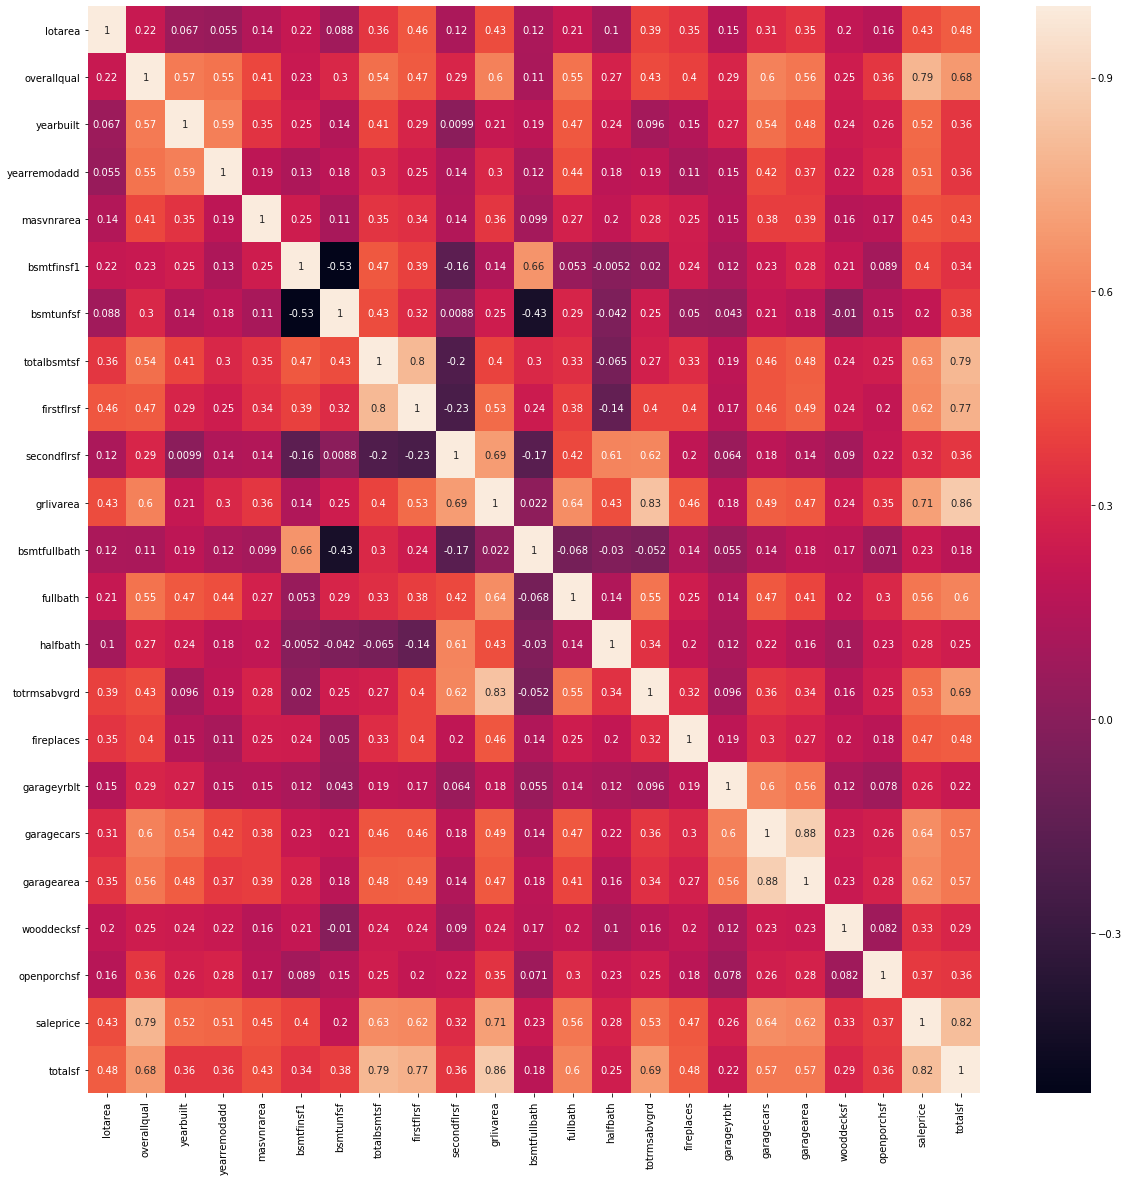

In [62]:
# See the correlation heatmap of the features
plt.figure(figsize=(20,20))
sns.heatmap(df_hp_2[num_cols_5].corr(),annot=True)

In [63]:
# Remove more colinear columns, but keep the variables with higher corr coef with saleprice
drop_list = ['garageyrblt','grlivarea', 'firstflrsf', 'saleprice', 'secondflrsf','totrmsabvgrd','garagearea','bsmtfinsf1','bsmtunfsf','totalbsmtsf']
df_hp_2 = df_hp_2.drop(drop_list, axis=1)

In [64]:
# Comparing correlation strength with "SalePrice", sorted on correlation value.
# NOTE: None of the variables have a strong negative relationship with "SalePrice"
num_corr = abs(df_hp_2[df_hp_2.columns[1:]].corr()['winsorized_saleprice'][:]).sort_values()
print(num_corr)

bsmtfullbath           0.241
halfbath               0.295
wooddecksf             0.345
openporchsf            0.397
lotarea                0.437
masvnrarea             0.449
fireplaces             0.489
yearremodadd           0.553
yearbuilt              0.570
fullbath               0.585
garagecars             0.673
overallqual            0.817
totalsf                0.822
winsorized_saleprice   1.000
Name: winsorized_saleprice, dtype: float64


In [65]:
num_cols_6 = df_hp_2.select_dtypes(['int64', 'float64']).columns.copy()
word_cols = df_hp_2.select_dtypes(include = object).columns.copy()

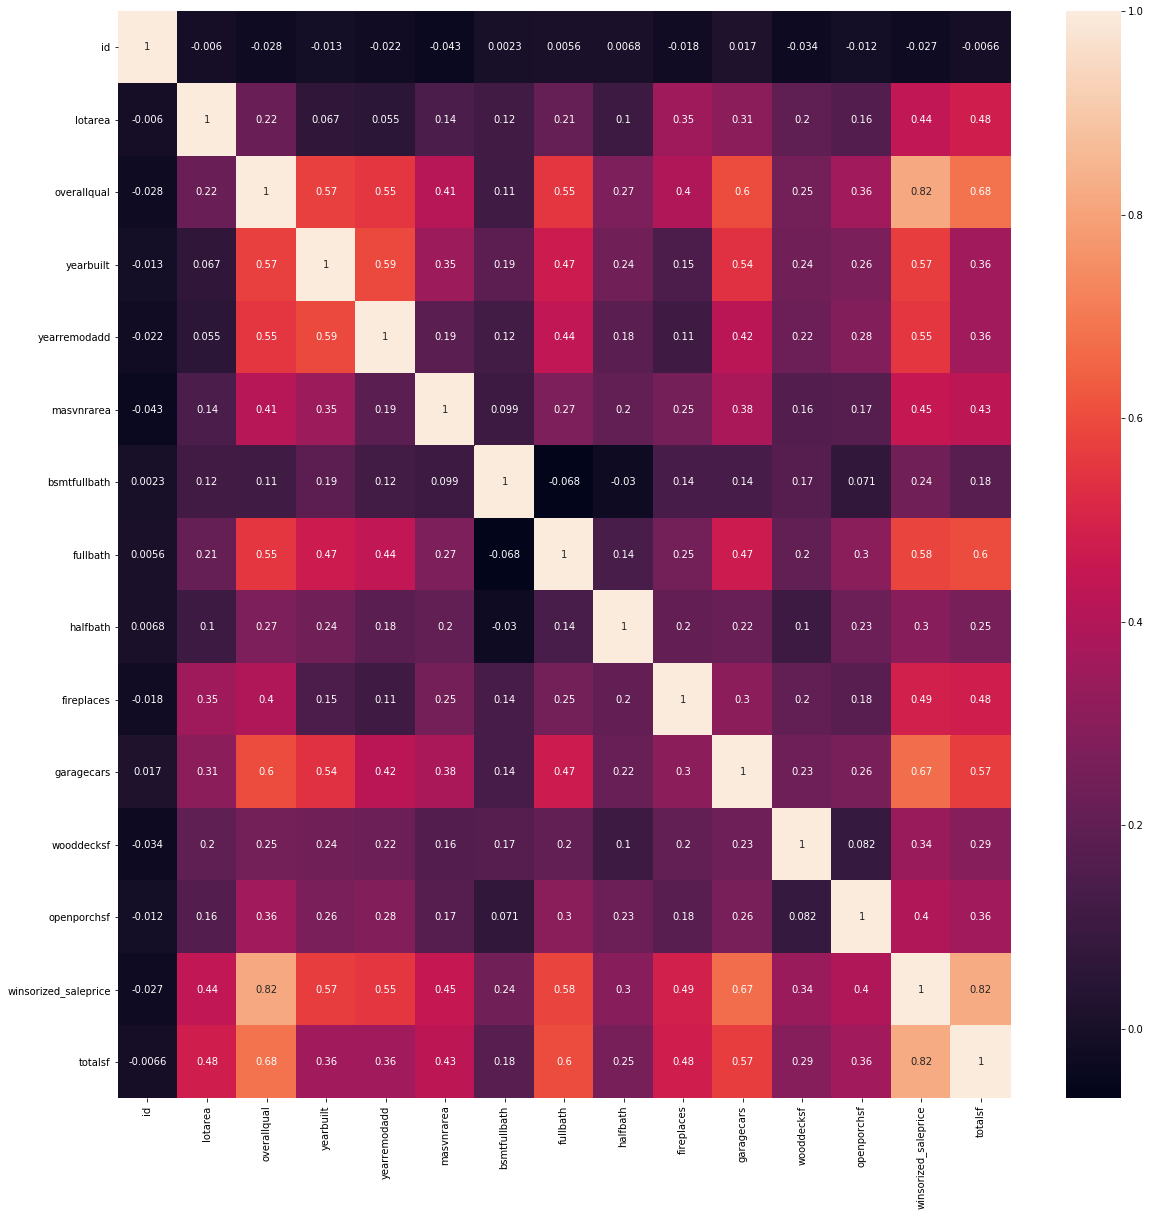

In [66]:
# See the correlation heatmap of the features
plt.figure(figsize=(20,20))
sns.heatmap(df_hp_2[num_cols_6].corr(),annot=True)

### Categorical Variable Selection

In [67]:
# new numeric column list
drop_num_list = [col_name for col_name in df_hp_2.select_dtypes(['int64', 'float64']).columns.copy()
              if col_name not in ["id", "winsorized_saleprice"]]

In [68]:
# new dummies df
df_dummies = df_hp_2.copy()

# drop columns from drop_num_list
df_dummies = df_dummies.drop(drop_num_list, axis = 1)

In [69]:
# running get dummies

# elected NOT to remove the first column because not every feature can be taken into account by deduction, especially where 
# multiple conditions are present. Also, not every dummy variable exists throughout the whole data set... like pools, alleys, 
# and fireplaces.

df_dummies= pd.get_dummies(data = df_dummies, columns = word_cols)

In [70]:
df_dummies.head()

id  winsorized_saleprice  mszoning_C (all)  mszoning_FV  mszoning_RH  \
0   1                208500                 0            0            0   
1   2                181500                 0            0            0   
2   3                223500                 0            0            0   
3   4                140000                 0            0            0   
4   5                250000                 0            0            0   

   mszoning_RL  mszoning_RM  street_Grvl  street_Pave  alley_Grvl  alley_NONE  \
0            1            0            0            1           0           1   
1            1            0            0            1           0           1   
2            1            0            0            1           0           1   
3            1            0            0            1           0           1   
4            1            0            0            1           0           1   

   alley_Pave  lotshape_IR1  lotshape_IR2  lotshape_IR3  lotshape_Reg  \
0           0             0             0             0             1   
1           0             0             0             0             1   
2           0             1             0             0             0   
3           0             1             0             0             0   
4           0             1             0             0             0   

   landcontour_Bnk  landcontour_HLS  landcontour_Low  landcontour_Lvl  \
0                0                0                0                1   
1                0                0                0                1   
2                0                0                0                1   
3                0                0                0                1   
4                0                0                0                1   

   utilities_AllPub  utilities_NoSeWa  lotconfig_Corner  lotconfig_CulDSac  \
0                 1                 0                 0                  0   
1                 1                 0                 0                  0   
2                 1                 0                 0                  0   
3                 1                 0                 1                  0   
4                 1                 0                 0                  0   

   lotconfig_FR2  lotconfig_FR3  lotconfig_Inside  landslope_Gtl  \
0              0              0                 1              1   
1              1              0                 0              1   
2              0              0                 1              1   
3              0              0                 0              1   
4              1              0                 0              1   

   landslope_Mod  landslope_Sev  neighborhood_Blmngtn  neighborhood_Blueste  \
0              0              0                     0                     0   
1              0              0                     0                     0   
2              0              0                     0                     0   
3              0              0                     0                     0   
4              0              0                     0                     0   

   neighborhood_BrDale  neighborhood_BrkSide  neighborhood_ClearCr  \
0                    0                     0                     0   
1                    0                     0                     0   
2                    0                     0                     0   
3                    0                     0                     0   
4                    0                     0                     0   

   neighborhood_CollgCr  neighborhood_Crawfor  neighborhood_Edwards  \
0                     1                     0                     0   
1                     0                     0                     0   
2                     1                     0                     0   
3                     0                     1                     0   
4                     0                     0             

In [71]:
correlation_cat = abs(df_dummies[df_dummies.columns[1:]].corr()['winsorized_saleprice'][:]).sort_values()
print(correlation_cat)

saletype_ConLI          0.000
lotconfig_Corner        0.001
roofmatl_Metal          0.001
lotconfig_FR2           0.001
fence_GdPrv             0.002
garagecond_Gd           0.003
roofstyle_Mansard       0.003
miscfeature_Gar2        0.004
electrical_NONE         0.004
condition2_RRAe         0.005
bsmtfintype2_GLQ        0.006
exterior1st_Plywood     0.006
foundation_Wood         0.006
roofmatl_ClyTile        0.007
condition1_RRNe         0.008
condition1_RRAn         0.008
roofmatl_Tar&Grv        0.011
foundation_Stone        0.011
garagequal_Ex           0.012
utilities_NoSeWa        0.016
utilities_AllPub        0.016
roofmatl_Roll           0.016
condition2_RRAn         0.016
salecondition_Alloca    0.016
extercond_Ex            0.016
exterior2nd_Stone       0.017
poolqc_Gd               0.017
bldgtype_TwnhsE         0.017
functional_Sev          0.019
heating_GasW            0.021
                         ... 
garagecond_TA           0.310
bsmtqual_Gd             0.311
mszoning_R

In [72]:
lower_cat_corr_df_2 = pd.DataFrame(correlation_cat)
lower_cat_corr_df_2.columns = ['CorrelationSalePrice']

In [73]:
to_drop_cat = lower_cat_corr_df_2[lower_cat_corr_df_2['CorrelationSalePrice'] < 0.2].index
# Drop features 
df_dummies_2 = df_dummies.drop(to_drop_cat, axis=1)

In [74]:
df_dummies_2.head()

id  winsorized_saleprice  mszoning_RL  mszoning_RM  lotshape_IR1  \
0   1                208500            1            0             0   
1   2                181500            1            0             0   
2   3                223500            1            0             1   
3   4                140000            1            0             1   
4   5                250000            1            0             1   

   lotshape_Reg  neighborhood_NAmes  neighborhood_NoRidge  \
0             1                   0                     0   
1             1                   0                     0   
2             0                   0                     0   
3             0                   0                     0   
4             0                   0                     1   

   neighborhood_NridgHt  neighborhood_OldTown  housestyle_2Story  \
0                     0                     0                  1   
1                     0                     0                  0   
2                     0                     0                  1   
3                     0                     0                  1   
4                     0                     0                  1   

   roofstyle_Gable  roofstyle_Hip  exterior1st_VinylSd  exterior2nd_VinylSd  \
0                1              0                    1                    1   
1                1              0                    0                    0   
2                1              0                    1                    1   
3                1              0                    0                    0   
4                1              0                    1                    1   

   masvnrtype_BrkFace  masvnrtype_None  masvnrtype_Stone  exterqual_Ex  \
0                   1                0                 0             0   
1                   0                1                 0             0   
2                   1                0                 0             0   
3                   0                1                 0             0   
4                   1                0                 0             0   

   exterqual_Gd  exterqual_TA  foundation_BrkTil  foundation_CBlock  \
0             1             0                  0                  0   
1             0             1                  0                  1   
2             1             0                  0                  0   
3             0             1                  1                  0   
4             1             0                  0                  0   

   foundation_PConc  bsmtqual_Ex  bsmtqual_Gd  bsmtqual_TA  bsmtexposure_Gd  \
0                 1            0            1            0                0   
1                 0            0            1            0                1   
2                 1            0            1            0                0   
3                 0            0            0            1                0   
4                 1            0            1            0                0   

   bsmtexposure_No  bsmtfintype1_GLQ  heatingqc_Ex  heatingqc_TA  \
0                1                 1             1             0   
1                0                 0             1             0   
2                0                 1             1             0   
3                1                 0             0             0   
4                0                 1             1             0   

   centralair_N  centralair_Y  electrical_FuseA  electrical_SBrkr  \
0             0             1                 0                 1   
1             0             1                 0                 1   
2             0             1                 0                 1   
3             0             1                 0                 1   
4             0             1                 0                 1   

   kitchenqual_Ex  kitchenqual_Gd  kitchenqual_TA  fireplacequ_Ex  \
0               0               1               0               0   
1               

### Merging numerical and dummy dataframes

In [75]:
# drop categorical variables from original data frame "df_hp_2"
df_hp_3 = df_hp_2.select_dtypes(exclude=['object'])

In [76]:
merged_df_hp = pd.merge(df_hp_3, df_dummies_2, on= ['id','winsorized_saleprice'])

In [77]:
merged_df_hp.head()

id  lotarea  overallqual  yearbuilt  yearremodadd  masvnrarea  \
0   1     8450            7       2003          2003     196.000   
1   2     9600            6       1976          1976       0.000   
2   3    11250            7       2001          2002     162.000   
3   4     9550            7       1915          1970       0.000   
4   5    14260            8       2000          2000     350.000   

   bsmtfullbath  fullbath  halfbath  fireplaces  garagecars  wooddecksf  \
0             1         2         1           0           2           0   
1             0         2         0           1           2         298   
2             1         2         1           1           2           0   
3             1         1         0           1           3           0   
4             1         2         1           1           3         192   

   openporchsf  winsorized_saleprice  totalsf  mszoning_RL  mszoning_RM  \
0           61                208500     2566            1            0   
1            0                181500     2524            1            0   
2           42                223500     2706            1            0   
3           35                140000     2473            1            0   
4           84                250000     3343            1            0   

   lotshape_IR1  lotshape_Reg  neighborhood_NAmes  neighborhood_NoRidge  \
0             0             1                   0                     0   
1             0             1                   0                     0   
2             1             0                   0                     0   
3             1             0                   0                     0   
4             1             0                   0                     1   

   neighborhood_NridgHt  neighborhood_OldTown  housestyle_2Story  \
0                     0                     0                  1   
1                     0                     0                  0   
2                     0                     0                  1   
3                     0                     0                  1   
4                     0                     0                  1   

   roofstyle_Gable  roofstyle_Hip  exterior1st_VinylSd  exterior2nd_VinylSd  \
0                1              0                    1                    1   
1                1              0                    0                    0   
2                1              0                    1                    1   
3                1              0                    0                    0   
4                1              0                    1                    1   

   masvnrtype_BrkFace  masvnrtype_None  masvnrtype_Stone  exterqual_Ex  \
0                   1                0                 0             0   
1                   0                1                 0             0   
2                   1                0                 0             0   
3                   0                1                 0             0   
4                   1                0                 0             0   

   exterqual_Gd  exterqual_TA  foundation_BrkTil  foundation_CBlock  \
0             1             0                  0                  0   
1             0             1                  0                  1   
2             1             0                  0                  0   
3             0             1                  1                  0   
4             1             0                  0                  0   

   foundation_PConc  bsmtqual_Ex  bsmtqual_Gd  bsmtqual_TA  bsmtexposure_Gd  \
0                 1            0            1            0                0   
1                 0            0            1            0                1   
2                 1            0            1            0                0   
3                 0            0            0            1                0   
4                 1            0            1            0                0   

   bsmtexp

In [78]:
merged_df_hp.shape

(1460, 72)

# PCA

In [79]:
# model feature list
feature_list = [col_name for col_name in merged_df_hp.select_dtypes(['int64', 'float64']).columns.copy()
              if col_name not in ["id", "winsorized_saleprice"]]

In [80]:
x = merged_df_hp[feature_list].values
y = merged_df_hp['winsorized_saleprice']
x = StandardScaler().fit_transform(x)

In [81]:
hp_pca = PCA(n_components=2)

principalComponents = hp_pca.fit_transform(x)

principalDataframe = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

In [82]:
#principalDataframe = pd.concat([principalDataframe, merged_df_hp], axis=1)
hp_pca_df = pd.concat([principalDataframe, merged_df_hp], axis=1)

In [83]:
hp_pca_df.head()

PC1    PC2  id  lotarea  overallqual  yearbuilt  yearremodadd  \
0  1.397 -1.519   1     8450            7       2003          2003   
1  0.159  0.434   2     9600            6       1976          1976   
2  1.811 -0.253   3    11250            7       2001          2002   
3 -0.582  1.383   4     9550            7       1915          1970   
4  3.866  0.615   5    14260            8       2000          2000   

   masvnrarea  bsmtfullbath  fullbath  halfbath  fireplaces  garagecars  \
0     196.000             1         2         1           0           2   
1       0.000             0         2         0           1           2   
2     162.000             1         2         1           1           2   
3       0.000             1         1         0           1           3   
4     350.000             1         2         1           1           3   

   wooddecksf  openporchsf  winsorized_saleprice  totalsf  mszoning_RL  \
0           0           61                208500     2566            1   
1         298            0                181500     2524            1   
2           0           42                223500     2706            1   
3           0           35                140000     2473            1   
4         192           84                250000     3343            1   

   mszoning_RM  lotshape_IR1  lotshape_Reg  neighborhood_NAmes  \
0            0             0             1                   0   
1            0             0             1                   0   
2            0             1             0                   0   
3            0             1             0                   0   
4            0             1             0                   0   

   neighborhood_NoRidge  neighborhood_NridgHt  neighborhood_OldTown  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   
3                     0                     0                     0   
4                     1                     0                     0   

   housestyle_2Story  roofstyle_Gable  roofstyle_Hip  exterior1st_VinylSd  \
0                  1                1              0                    1   
1                  0                1              0                    0   
2                  1                1              0                    1   
3                  1                1              0                    0   
4                  1                1              0                    1   

   exterior2nd_VinylSd  masvnrtype_BrkFace  masvnrtype_None  masvnrtype_Stone  \
0                    1                   1                0                 0   
1                    0                   0                1                 0   
2                    1                   1                0                 0   
3                    0                   0                1                 0   
4                    1                   1                0                 0   

   exterqual_Ex  exterqual_Gd  exterqual_TA  foundation_BrkTil  \
0             0             1             0                  0   
1             0             0             1                  0   
2             0             1             0                  0   
3             0             0             1                  1   
4             0             1             0                  0   

   foundation_CBlock  foundation_PConc  bsmtqual_Ex  bsmtqual_Gd  bsmtqual_TA  \
0                  0                 1            0            1            0   
1                  1                 0            0            1            0   
2                  0                 1            0            1            0   
3                  0                 0            0            0            1   
4                  0                 1            0            1            0   

   bsmtexposure_Gd  bsmtexposu

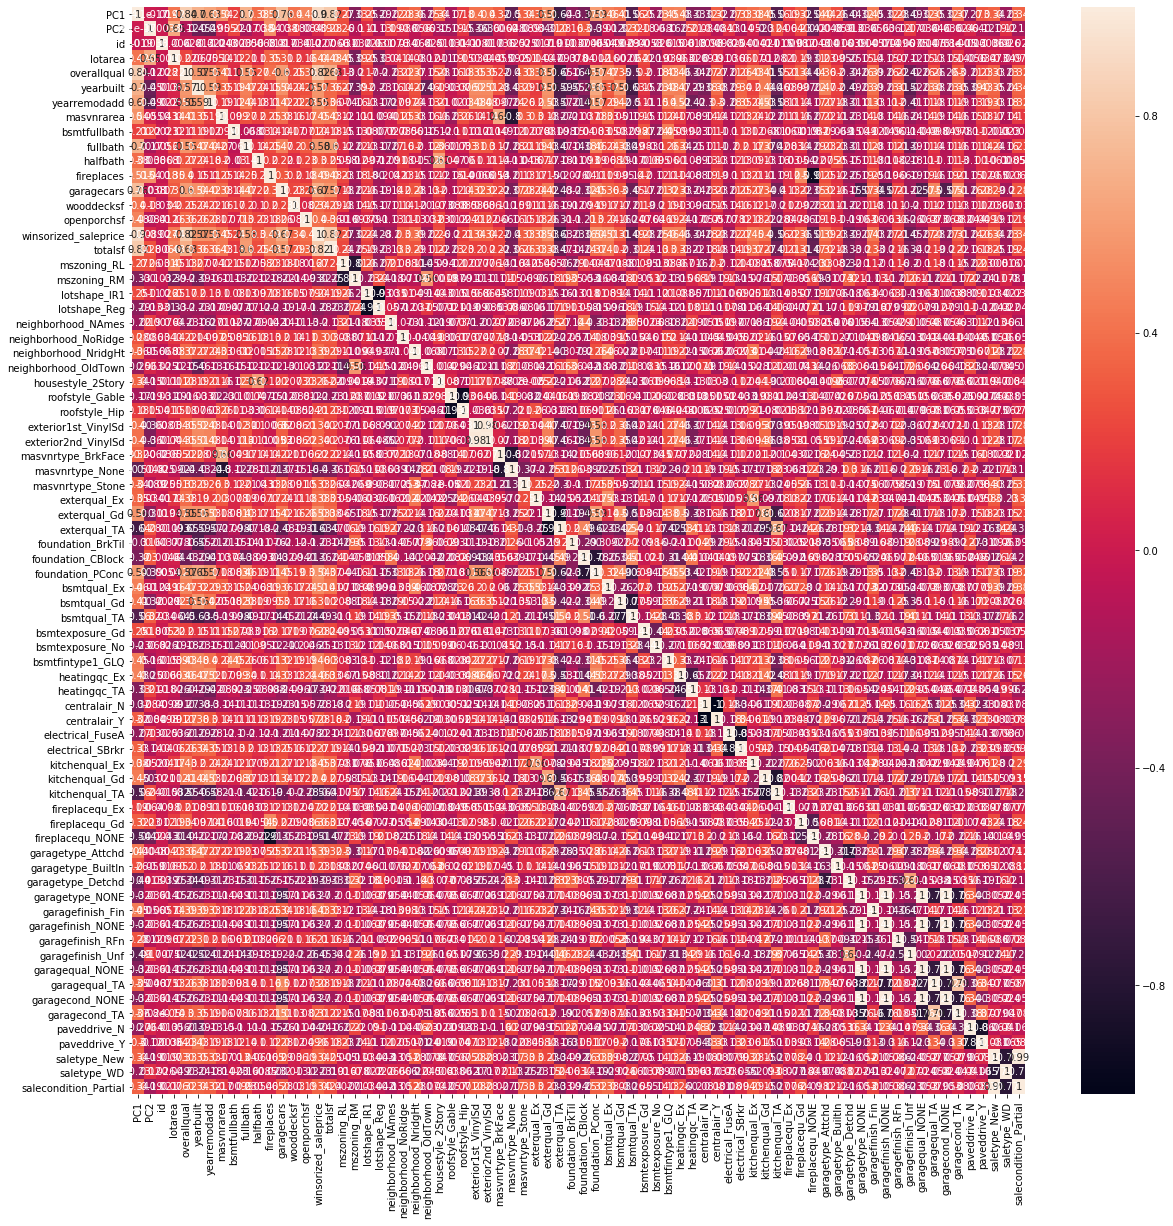

In [84]:
# See the correlation heatmap of the features
plt.figure(figsize=(20,20))
sns.heatmap(hp_pca_df.corr(),annot=True)

In [85]:
correlation_cat = abs(hp_pca_df[hp_pca_df.columns[0:]].corr()['winsorized_saleprice'][:]).sort_values()
print(correlation_cat)

id                     0.027
PC2                    0.089
neighborhood_NAmes     0.200
roofstyle_Gable        0.203
roofstyle_Hip          0.210
garagefinish_RFn       0.214
electrical_FuseA       0.216
neighborhood_OldTown   0.217
masvnrtype_BrkFace     0.223
fireplacequ_Ex         0.224
saletype_WD            0.226
foundation_BrkTil      0.229
garagetype_BuiltIn     0.231
paveddrive_N           0.238
bsmtfullbath           0.241
lotshape_IR1           0.241
bsmtexposure_No        0.254
paveddrive_Y           0.259
housestyle_2Story      0.260
garagefinish_NONE      0.268
garagecond_NONE        0.268
garagequal_NONE        0.268
garagetype_NONE        0.268
mszoning_RL            0.268
electrical_SBrkr       0.270
garagequal_TA          0.277
bsmtexposure_Gd        0.281
lotshape_Reg           0.283
centralair_Y           0.284
centralair_N           0.284
                        ... 
exterqual_Ex           0.376
garagetype_Attchd      0.387
neighborhood_NridgHt   0.388
garagetype_Det

In [86]:
correlation_df_pc1 = abs(hp_pca_df[hp_pca_df.columns[0:]].corr()['PC1'][:]).sort_values()
print(correlation_df_pc1)

PC2                    0.000
id                     0.019
roofstyle_Gable        0.168
roofstyle_Hip          0.185
fireplacequ_Ex         0.193
bsmtfullbath           0.211
neighborhood_NAmes     0.218
saletype_WD            0.225
bsmtexposure_No        0.229
neighborhood_OldTown   0.245
lotshape_IR1           0.247
bsmtexposure_Gd        0.248
garagetype_BuiltIn     0.256
mszoning_RL            0.267
paveddrive_N           0.270
electrical_FuseA       0.271
garagefinish_RFn       0.275
neighborhood_NoRidge   0.282
lotshape_Reg           0.293
paveddrive_Y           0.296
foundation_BrkTil      0.297
centralair_Y           0.316
centralair_N           0.316
fireplacequ_Gd         0.319
garagetype_NONE        0.321
garagefinish_NONE      0.321
garagequal_NONE        0.321
garagecond_NONE        0.321
masvnrtype_BrkFace     0.323
electrical_SBrkr       0.329
                        ... 
exterior2nd_VinylSd    0.401
wooddecksf             0.402
bsmtqual_Gd            0.413
lotarea       

In [87]:
correlation_df_pc2 = abs(hp_pca_df[hp_pca_df.columns[0:]].corr()['PC2'][:]).sort_values()
print(correlation_df_pc2)

PC1                     0.000
id                      0.003
garagetype_Attchd       0.005
masvnrtype_BrkFace      0.006
bsmtqual_Ex             0.012
garagetype_Detchd       0.013
garagecond_TA           0.024
exterqual_Ex            0.034
garagequal_NONE         0.036
garagefinish_NONE       0.036
garagecond_NONE         0.036
garagetype_NONE         0.036
halfbath                0.038
garagecars              0.038
garagequal_TA           0.046
masvnrtype_None         0.048
kitchenqual_Ex          0.052
masvnrarea              0.055
garagefinish_Fin        0.056
neighborhood_NridgHt    0.056
garagetype_BuiltIn      0.059
neighborhood_OldTown    0.063
paveddrive_N            0.064
fireplacequ_Ex          0.064
bsmtexposure_No         0.068
centralair_N            0.084
centralair_Y            0.084
openporchsf             0.084
neighborhood_NoRidge    0.086
winsorized_saleprice    0.089
                         ... 
garagefinish_Unf        0.171
fullbath                0.173
wooddecksf

In [88]:
lower_corr_df = pd.DataFrame(correlation_df_pc1)

lower_corr_df.columns = ['correlation_df_pc1']
lower_corr_df = lower_corr_df.drop(['id','winsorized_saleprice'])

In [89]:
to_drop_corr = lower_corr_df[lower_corr_df['correlation_df_pc1'] < 0.5].index
print(to_drop_corr)

Index(['PC2', 'roofstyle_Gable', 'roofstyle_Hip', 'fireplacequ_Ex',
       'bsmtfullbath', 'neighborhood_NAmes', 'saletype_WD', 'bsmtexposure_No',
       'neighborhood_OldTown', 'lotshape_IR1', 'bsmtexposure_Gd',
       'garagetype_BuiltIn', 'mszoning_RL', 'paveddrive_N', 'electrical_FuseA',
       'garagefinish_RFn', 'neighborhood_NoRidge', 'lotshape_Reg',
       'paveddrive_Y', 'foundation_BrkTil', 'centralair_Y', 'centralair_N',
       'fireplacequ_Gd', 'garagetype_NONE', 'garagefinish_NONE',
       'garagequal_NONE', 'garagecond_NONE', 'masvnrtype_BrkFace',
       'electrical_SBrkr', 'heatingqc_TA', 'mszoning_RM',
       'salecondition_Partial', 'masvnrtype_Stone', 'housestyle_2Story',
       'saletype_New', 'garagequal_TA', 'exterqual_Ex', 'neighborhood_NridgHt',
       'garagecond_TA', 'foundation_CBlock', 'halfbath', 'kitchenqual_Ex',
       'exterior1st_VinylSd', 'exterior2nd_VinylSd', 'wooddecksf',
       'bsmtqual_Gd', 'lotarea', 'garagetype_Attchd', 'garagetype_Detchd',
    

In [90]:
# Drop features 
hp_pca_df_2 = hp_pca_df.drop(to_drop_corr, axis=1)

In [91]:
hp_pca_df_2.head()

PC1  id  overallqual  yearbuilt  yearremodadd  masvnrarea  fullbath  \
0  1.397   1            7       2003          2003     196.000         2   
1  0.159   2            6       1976          1976       0.000         2   
2  1.811   3            7       2001          2002     162.000         2   
3 -0.582   4            7       1915          1970       0.000         1   
4  3.866   5            8       2000          2000     350.000         2   

   fireplaces  garagecars  winsorized_saleprice  totalsf  masvnrtype_None  \
0           0           2                208500     2566                0   
1           1           2                181500     2524                1   
2           1           2                223500     2706                0   
3           1           3                140000     2473                1   
4           1           3                250000     3343                0   

   exterqual_Gd  exterqual_TA  foundation_PConc  bsmtqual_TA  kitchenqual_TA  \
0             1             0                 1            0               0   
1             0             1                 0            0               1   
2             1             0                 1            0               0   
3             0             1                 0            1               0   
4             1             0                 1            0               0   

   fireplacequ_NONE  
0                 1  
1                 0  
2                 0  
3                 0  
4                 0

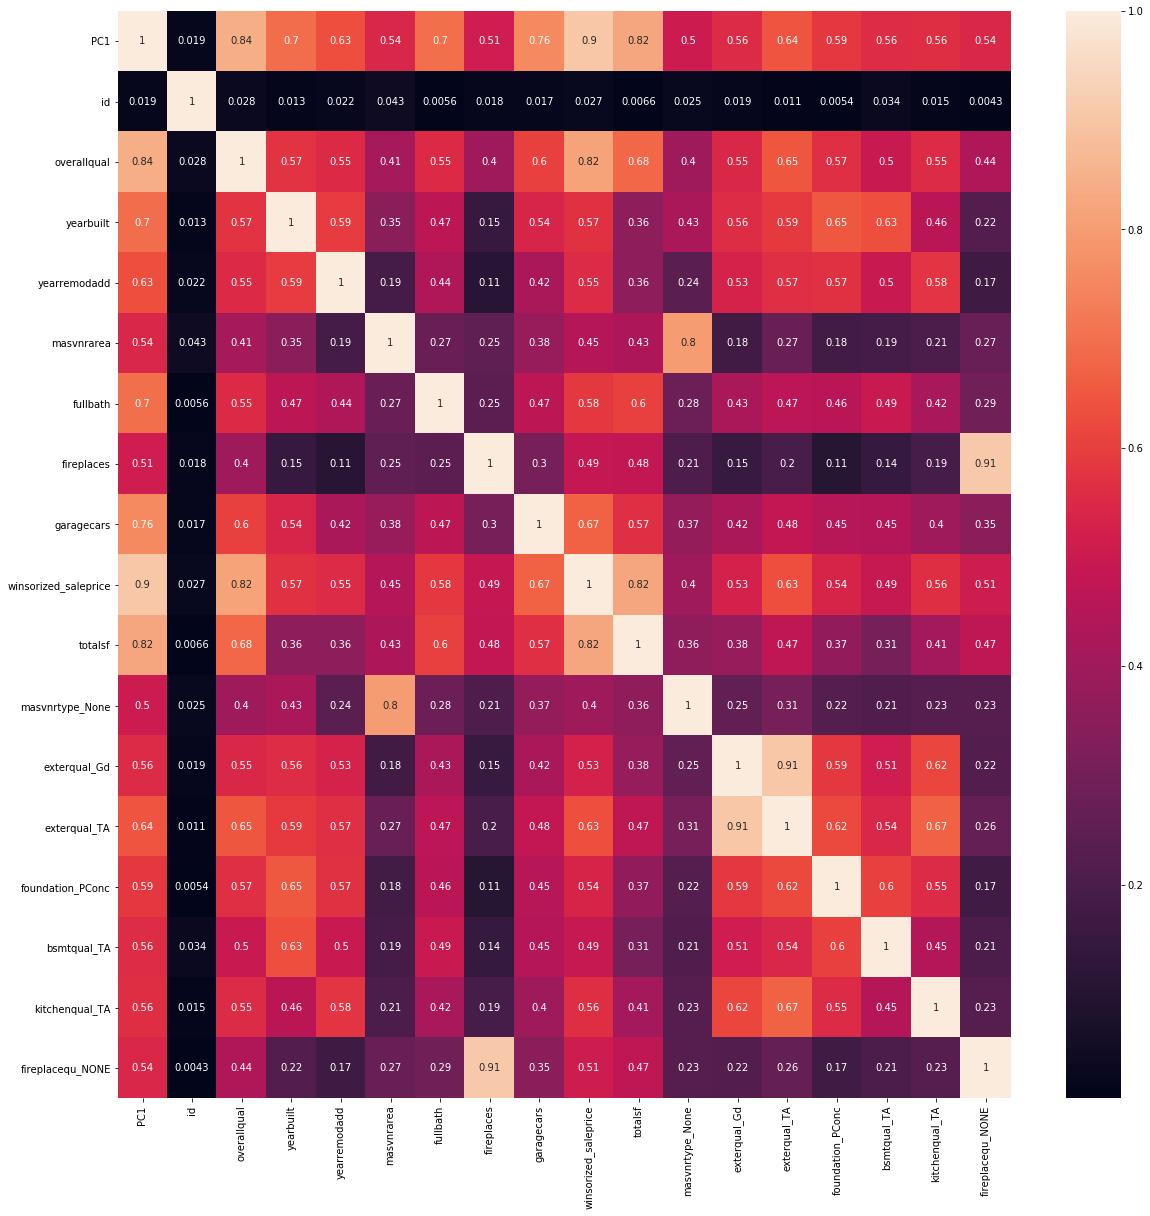

In [92]:
# See the correlation heatmap of the features
plt.figure(figsize=(20,20))
sns.heatmap(abs(hp_pca_df_2.corr()),annot=True)

In [93]:
drop_list_2 = ['exterqual_Gd', 'PC1', 'fireplacequ_NONE', 'masvnrtype_None']

In [94]:
hp_pca_df_3 = hp_pca_df_2.drop(drop_list_2, axis = 1)

In [95]:
# model feature list
feature_list_2 = [col_name for col_name in hp_pca_df_3.select_dtypes(['int64', 'float64']).columns.copy()
              if col_name not in ["id", "winsorized_saleprice"]]

### Linear Regression Model

In [96]:
X = hp_pca_df_3[feature_list_2]
Y = np.log1p(hp_pca_df_3['winsorized_saleprice'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [97]:
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     winsorized_saleprice   R-squared:                       0.838
Model:                              OLS   Adj. R-squared:                  0.837
Method:                   Least Squares   F-statistic:                     747.5
Date:                  Sun, 05 Jul 2020   Prob (F-statistic):               0.00
Time:                          15:31:14   Log-Likelihood:                 544.72
No. Observations:                  1168   AIC:                            -1071.
Df Residuals:                      1159   BIC:                            -1026.
Df Model:                             8                                         
Covariance Type:              nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.8227     

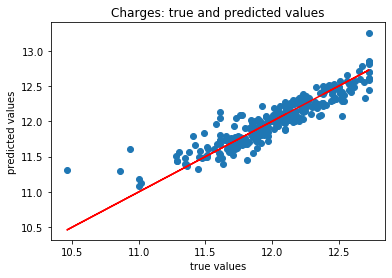

Mean absolute error of the prediction is: 0.1100320876962181
Mean squared error of the prediction is: 0.023148506674548718
Root mean squared error of the prediction is: 0.15214633309596626
Mean absolute percentage error of the prediction is: 0.9225168035083022


In [98]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))



R-squared of the model in the training set is: 0.8376449710690886
-----Test set statistics-----
R-squared of the model in the test set is: 0.8443779683680244
Mean absolute error of the prediction is: 0.11003208769621511
Mean squared error of the prediction is: 0.02314850667454877
Root mean squared error of the prediction is: 0.15214633309596642
Mean absolute percentage error of the prediction is: 0.9225168035082809


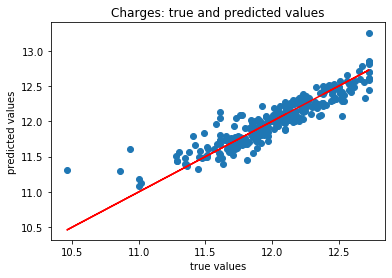

In [99]:
# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

Best alpha value is: 1e-10
R-squared of the model in training set is: 0.8376449710690886
-----Test set statistics-----
R-squared of the model in test set is: 0.8443779684477598
Mean absolute error of the prediction is: 0.1100320876561431
Mean squared error of the prediction is: 0.02314850666268827
Root mean squared error of the prediction is: 0.15214633305698916
Mean absolute percentage error of the prediction is: 0.9225168031845402


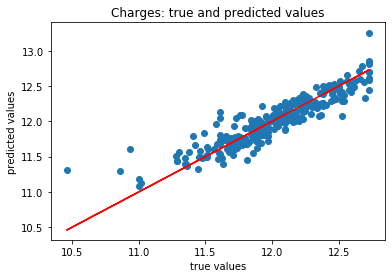

In [100]:
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

Best alpha value is: 1.0
R-squared of the model on the training set is: 0.8376447872543032
-----Test set statistics-----
R-squared of the model on the test set is: 0.84441442100294
Mean absolute error of the prediction is: 0.11001043772443378
Mean squared error of the prediction is: 0.02314308440847375
Root mean squared error of the prediction is: 0.15212851280569908
Mean absolute percentage error of the prediction is: 0.9223407806034


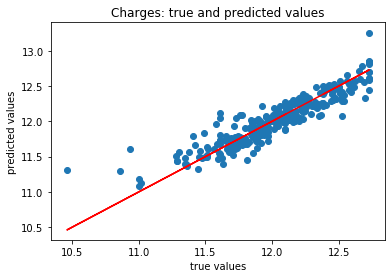

In [101]:
ridgeregr = RidgeCV(alphas=alphas, cv = 5) 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("Best alpha value is: {}".format(ridgeregr.alpha_))
print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

Best alpha value is: 1e-10
R-squared of the model on the training set is: 0.8376449710690889
-----Test set statistics-----
R-squared of the model on the test set is: 0.8443779684100329
Mean absolute error of the prediction is: 0.11003208767491302
Mean squared error of the prediction is: 0.02314850666830011
Root mean squared error of the prediction is: 0.1521463330754314
Mean absolute percentage error of the prediction is: 0.9225168033361174


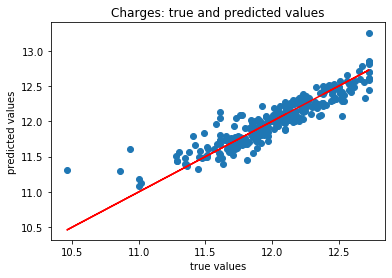

In [102]:
elasticregr = ElasticNetCV(alphas=alphas, cv=5)
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("Best alpha value is: {}".format(elasticregr.alpha_))
print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

The Ridge Regression model appears to have the best metrics. R-sqaured is highest for the test set and the additional metrics are lower across the board compared to the other models. All models were very similar in terms of goodness of fit and metrics.
- R-squared for the training set is 0.837
- R-squared for the test set is 0.844
- MAE is 0.110
- MSE is 0.023
- RMSE is 0.152
- MAPE is 0.922

### Adding in external data and applying to model.

In [103]:
external_data_df = pd.read_csv('ExternalData_Module17_Challenge.csv')
external_data_list = external_data_df.columns.copy()
external_data_df.head()

numeric_dates  IntRate  MortgagePts  GDPBillions  PercChangeQtrly  \
0           2006    5.710        0.500    13603.933            5.400   
1           4012    5.860        0.600    13603.933            5.400   
2           6018    5.970        0.600    13603.933            5.400   
3           8024    6.160        0.500    13749.806            0.900   
4          10030    6.210        0.500    13749.806            0.900   

   UnempRate  StressIndex  
0      4.700       -0.903  
1      4.800       -1.042  
2      4.700       -1.005  
3      4.700       -0.967  
4      4.600       -0.917

In [104]:
feature_list_3 = hp_pca_df_3.columns.copy()

In [105]:
merged_df_2 = pd.merge(df_hp, external_data_df, on= ['numeric_dates'])

In [106]:
merged_df_2.sample(10)

id  mssubclass mszoning  lotfrontage  lotarea street alley lotshape  \
988   1223          50       RL       78.000    10496   Pave  NONE      Reg   
77    1034          20       RL        0.000     8125   Pave  NONE      Reg   
985    877          20       RL       94.000    17400   Pave  NONE      Reg   
192    410          60       FV       85.000    10800   Pave  NONE      Reg   
1180   562          20       RL       77.000    10010   Pave  NONE      Reg   
225    129          60       RL       69.000     7590   Pave  NONE      Reg   
709    210          20       RL       75.000     8250   Pave  NONE      Reg   
147    956          90       RH       82.000     7136   Pave  NONE      IR1   
912    557          20       RL       69.000    14850   Pave  NONE      IR1   
490    957         160       RM       24.000     1680   Pave  NONE      Reg   

     landcontour utilities lotconfig landslope neighborhood condition1  \
988          Lvl    AllPub    Inside       Gtl        NAmes     Artery   
77           Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
985          HLS    AllPub    Inside       Mod      Mitchel       Norm   
192          Lvl    AllPub    Inside       Gtl      Somerst       Norm   
1180         Lvl    AllPub    Inside       Mod      Mitchel       Norm   
225          Lvl    AllPub    Inside       Gtl        NAmes       PosN   
709          Lvl    AllPub    Inside       Gtl        NAmes       Norm   
147          HLS    AllPub    Inside       Gtl      Crawfor       Norm   
912          Lvl    AllPub    Inside       Gtl        NAmes       Norm   
490          Lvl    AllPub    Inside       Gtl      Blueste       Norm   

     condition2 bldgtype housestyle  overallqual  overallcond  yearbuilt  \
988        Norm     1Fam     1.5Fin            6            6       1949   
77         Norm     1Fam     1Story            7            5       2002   
985        Norm     1Fam     1Story            4            5       1963   
192        Norm     1Fam     2Story            8            5       2007   
1180       Norm     1Fam     1Story            5            5       1974   
225        Norm     1Fam     2Story            6            5       1966   
709        Norm     1Fam     1Story            6            7       1964   
147        Norm   Duplex     2Story            6            6       1946   
912        Norm     1Fam     1Story            5            5       1957   
490        Norm   TwnhsE     2Story            6            6       1980   

      yearremodadd roofstyle roofmatl exterior1st exterior2nd masvnrtype  \
988           1950     Gable  CompShg     Wd Sdng     Wd Sdng    BrkFace   
77            2002     Gable  CompShg     VinylSd     VinylSd      Stone   
985           1963     Gable  CompShg     HdBoard     Plywood       None   
192           2008     Gable  CompShg     VinylSd     VinylSd      Stone   
1180          1975     Gable  CompShg     HdBoard     HdBoard       None   
225           1966     Gable  CompShg     VinylSd     VinylSd    BrkFace   
709           1964       Hip  CompShg     HdBoard     HdBoard      Stone   
147           1950     Gable  CompShg     MetalSd     MetalSd    BrkFace   
912           1957     Gable  CompShg     Wd Sdng     Wd Sdng       None   
490           1980     Gable  CompShg     MetalSd     MetalSd       None   

      masvnrarea exterqual extercond foundation bsmtqual bsmtcond  \
988      320.000        TA        TA     CBlock       TA       TA   
77       295.000        Gd        TA      PConc       Gd       TA   
985        0.000        TA        TA      PConc       TA       TA   
192      100.000        Gd        TA      PConc       Ex       TA   
1180       0.000        TA        TA     CBlock       Gd       TA   
225      266.000        TA        TA     CBlock       TA       TA   
709      260.000        TA        TA     CBlock       Gd       TA   
147      391.000        TA        TA     CBlock       Gd       TA   
912        0.000        TA  

In [107]:
target_list = merged_df_2[['id','winsorized_saleprice']].columns.copy()

In [108]:
# combine target list with external data list
# the * unpacks both iterables in a list literal so we can add them to 1 comprehensive list
new_ext_list = [*target_list, *external_data_list] 

In [109]:
new_external_df = merged_df_2[new_ext_list].copy()

In [110]:
merged_df_3 = pd.merge(hp_pca_df_3, new_external_df, on= ['id','winsorized_saleprice'])

In [111]:
merged_df_3.head()

id  overallqual  yearbuilt  yearremodadd  masvnrarea  fullbath  fireplaces  \
0   1            7       2003          2003     196.000         2           0   
1   2            6       1976          1976       0.000         2           1   
2   3            7       2001          2002     162.000         2           1   
3   4            7       1915          1970       0.000         1           1   
4   5            8       2000          2000     350.000         2           1   

   garagecars  winsorized_saleprice  totalsf  exterqual_TA  foundation_PConc  \
0           2                208500     2566             0                 1   
1           2                181500     2524             1                 0   
2           2                223500     2706             0                 1   
3           3                140000     2473             1                 0   
4           3                250000     3343             0                 1   

   bsmtqual_TA  kitchenqual_TA  numeric_dates  IntRate  MortgagePts  \
0            0               0           4016    5.440        0.500   
1            0               1          10035    5.970        0.400   
2            0               0          18072    5.640        0.600   
3            1               0           4012    5.860        0.600   
4            0               0          24096    5.040        0.700   

   GDPBillions  PercChangeQtrly  UnempRate  StressIndex  
0    14651.039           -2.300      4.900        1.256  
1    14382.363            2.300      4.400       -0.845  
2    14835.187           -2.100      6.100        3.028  
3    13603.933            5.400      4.800       -1.042  
4    14559.543           -8.400      7.300        5.455

In [112]:
# model feature list
feature_list_3 = [col_name for col_name in merged_df_3.select_dtypes(['int64', 'float64']).columns.copy()
              if col_name not in ["id", "winsorized_saleprice"]]

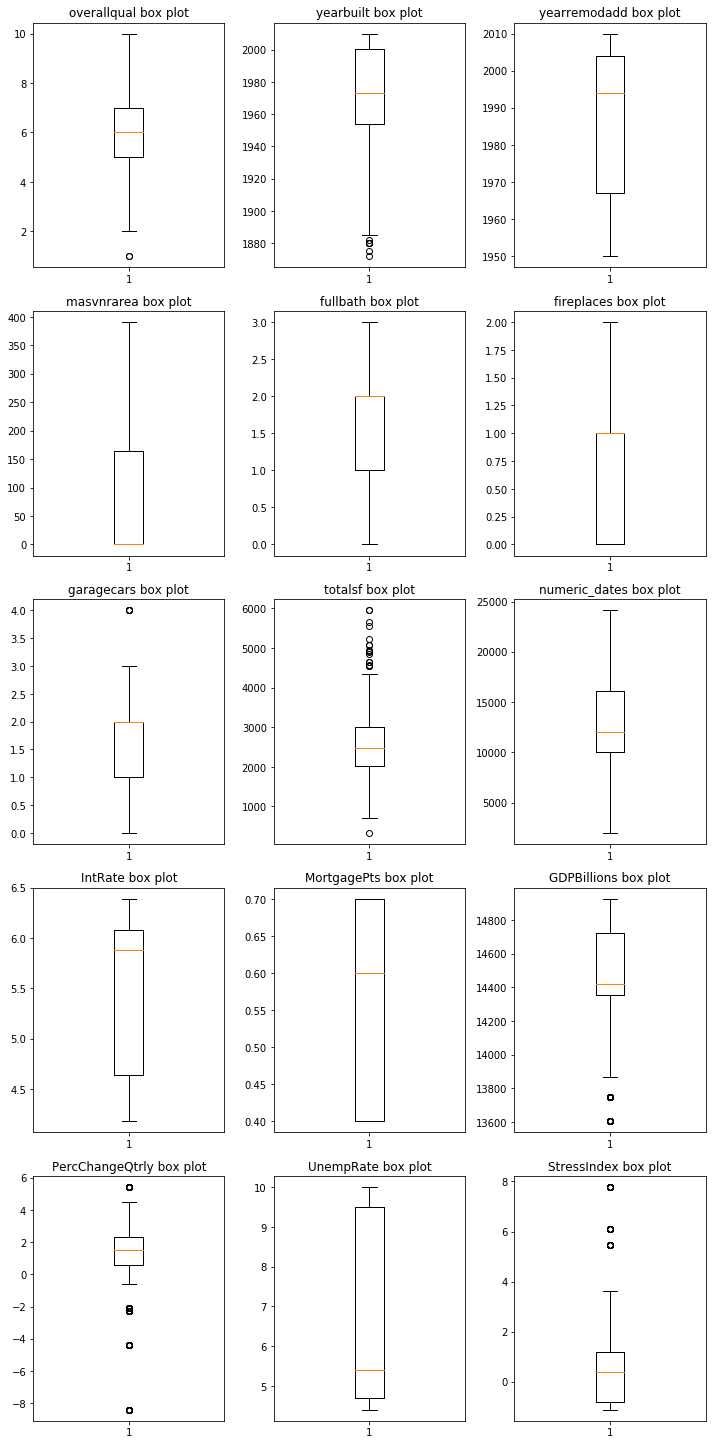

In [113]:
# box plots of to viualize outliers

def draw_box(df, columns, n_rows, n_cols):
    fig=plt.figure(figsize =(10, 60))
    for i, var_name in enumerate(columns):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        ax.boxplot(df[var_name])
        ax.set_title(var_name + ' box plot')
    fig.tight_layout()
    plt.show()
    
draw_box(merged_df_3, feature_list_3, len(feature_list_3), 3)

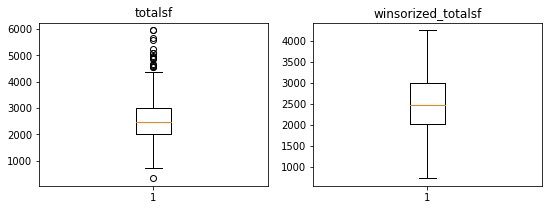

In [114]:
# Removing Outliers in the variables using Winsorization technique.
#Winsorize totalsf
plt.figure(figsize=(9,3))

plt.subplot(1,2,1)
original_totalsf = merged_df_3['totalsf']
plt.boxplot(original_totalsf)
plt.title("totalsf")

plt.subplot(1,2,2)
merged_df_3['totalsf'] = winsorize(merged_df_3['totalsf'], (0.001, 0.015))
winsorized_merged_df_3 = merged_df_3['totalsf']
plt.boxplot(merged_df_3['totalsf'])
plt.title("winsorized_totalsf")

plt.show()

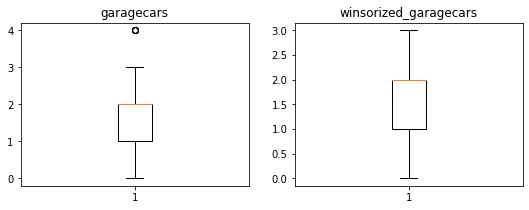

In [115]:
# Removing Outliers in the variables using Winsorization technique.
#Winsorize garagecars
plt.figure(figsize=(9,3))

plt.subplot(1,2,1)
original_garagecars = merged_df_3['garagecars']
plt.boxplot(original_garagecars)
plt.title("garagecars")

plt.subplot(1,2,2)
merged_df_3['garagecars'] = winsorize(merged_df_3['garagecars'], (0.00, 0.004))
winsorized_merged_df_3 = merged_df_3['garagecars']
plt.boxplot(merged_df_3['garagecars'])
plt.title("winsorized_garagecars")

plt.show()

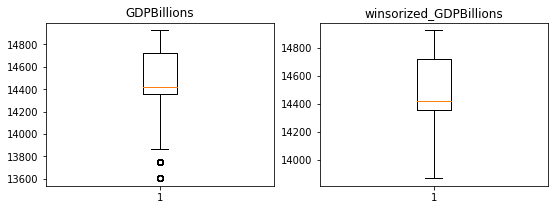

In [116]:
# Removing Outliers in the variables using Winsorization technique.
#Winsorize GDPBillions
plt.figure(figsize=(9,3))

plt.subplot(1,2,1)
original_GDPBillions = merged_df_3['GDPBillions']
plt.boxplot(original_GDPBillions)
plt.title("GDPBillions")

plt.subplot(1,2,2)
merged_df_3['GDPBillions'] = winsorize(merged_df_3['GDPBillions'], (0.11, 0.00))
winsorized_merged_df_3 = merged_df_3['GDPBillions']
plt.boxplot(merged_df_3['GDPBillions'])
plt.title("winsorized_GDPBillions")

plt.show()

In [117]:
feature_list_3

['overallqual',
 'yearbuilt',
 'yearremodadd',
 'masvnrarea',
 'fullbath',
 'fireplaces',
 'garagecars',
 'totalsf',
 'numeric_dates',
 'IntRate',
 'MortgagePts',
 'GDPBillions',
 'PercChangeQtrly',
 'UnempRate',
 'StressIndex']

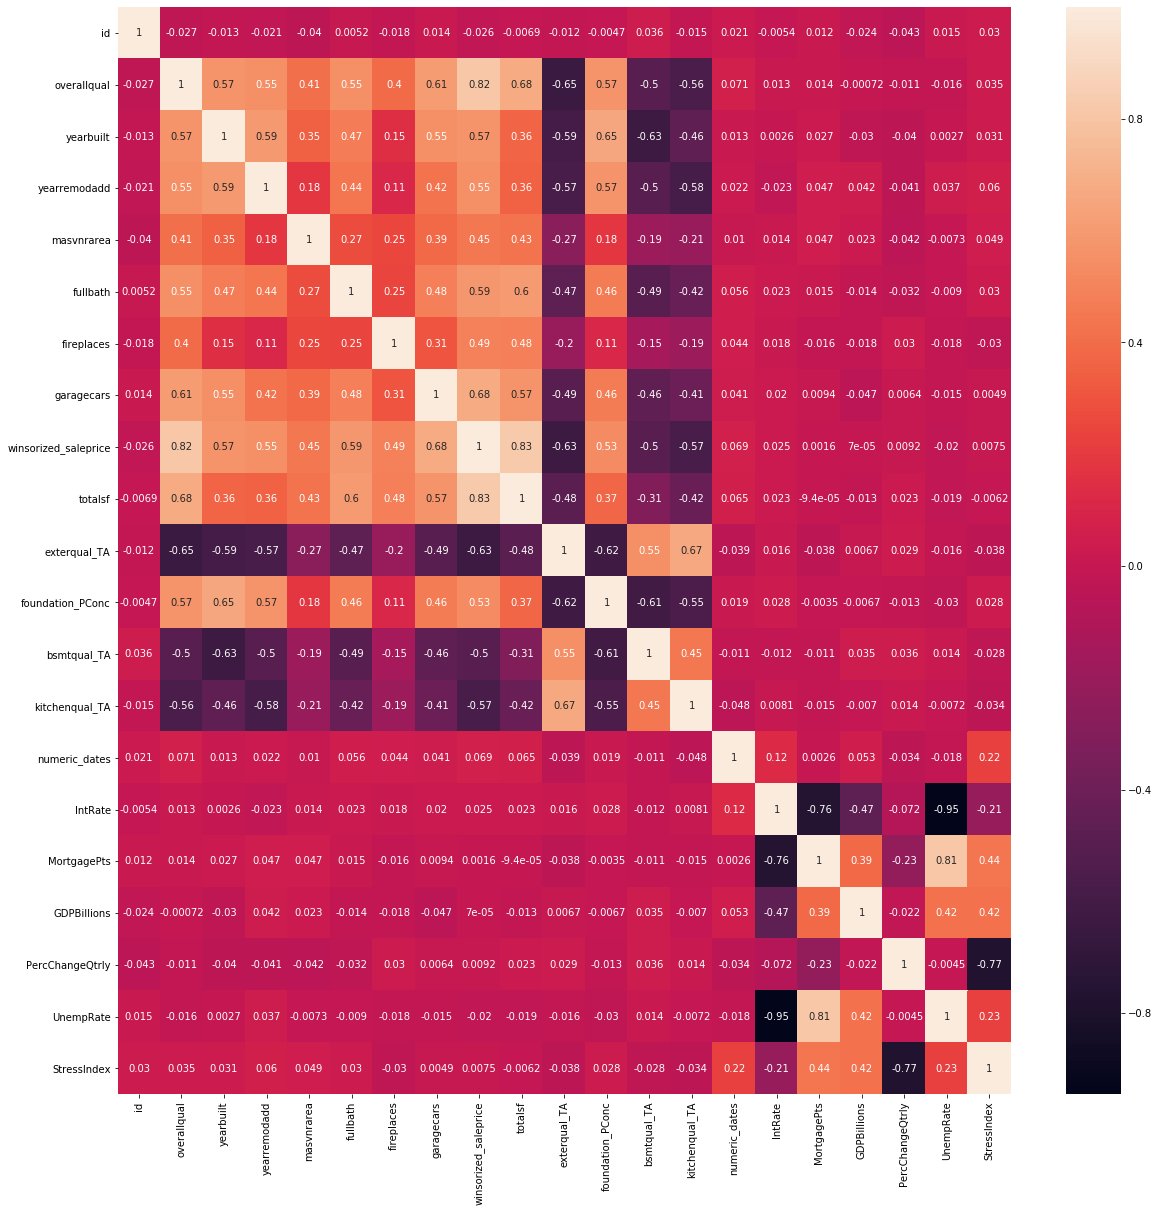

In [118]:
# See the correlation heatmap of the features
plt.figure(figsize=(20,20))
sns.heatmap(merged_df_3.corr(),annot=True)

In [119]:
X = merged_df_3[feature_list_3]
Y = np.log1p(merged_df_3['winsorized_saleprice'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1163
The number of observations in test set is 291


In [120]:
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     winsorized_saleprice   R-squared:                       0.857
Model:                              OLS   Adj. R-squared:                  0.855
Method:                   Least Squares   F-statistic:                     458.9
Date:                  Sun, 05 Jul 2020   Prob (F-statistic):               0.00
Time:                          15:31:22   Log-Likelihood:                 605.01
No. Observations:                  1163   AIC:                            -1178.
Df Residuals:                      1147   BIC:                            -1097.
Df Model:                            15                                         
Covariance Type:              nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.

In [121]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

Best alpha value is: 10.0
R-squared of the model on the training set is: 0.857141610324046
-----Test set statistics-----
R-squared of the model on the test set is: 0.8063842715659655
Mean absolute error of the prediction is: 0.11335192702764368
Mean squared error of the prediction is: 0.025900860493368455
Root mean squared error of the prediction is: 0.16093744279492095
Mean absolute percentage error of the prediction is: 0.9505110110626874


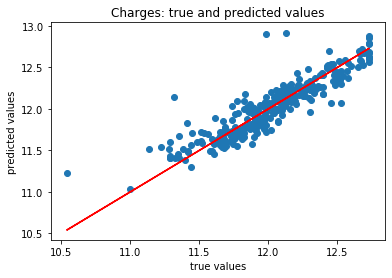

In [122]:
ridgeregr = RidgeCV(alphas=alphas, cv = 5) 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("Best alpha value is: {}".format(ridgeregr.alpha_))
print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

Added the following external variables to the model: interest rate, mortgage points, GDP in billions($), percent change in GDP, unemployment rate, financial stress index. <br> 

- R-squared for the training set increased from 0.837 to 0.857
- R-squared for the test set decreased from 0.844 to 0.806
- MAE increased from 0.110 to 0.113
- MSE increased from 0.023 to 0.025
- RMSE increased from 0.152 to 0.161
- MAPE increased from 0.922 to 0.951

Looking at the P-values for the coefficients, the only statistically impactful feature that was added was GDP, followed by interest rates. This could suggest the model would fair just about the same without the majority of the new features. <br>

In summary, the new data seems to perform worse in the test set with the new data. R-squared decreases and the performance metrics increase. Possible reasons for the degradation of the model could be explained the following:
 - Macro economic of the USA is measured at a larger scale than house prices in one location
 - Some features aren't measured on the same timeline (quarterly vs monthly)
 - Factors not taken into consideration includes location features, personal finances, and market price vs negotiated contract price
 - It's likely that the housing market will follow macro economic trends on average but the specific features of each home will be responsible for the amount of variation of the value based on the local competition. 